In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings('ignore')

In [47]:
df = pd.read_csv("/content/drive/MyDrive/AIFE PROJECT/data/stock_data.csv")


df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.date


df_agg = df.groupby(['Date', 'Symbol'])['Close Price'].mean().reset_index()

pivoted_df = df_agg.pivot(index='Date', columns='Symbol', values='Close Price')

all_symbols = df_agg['Symbol'].unique()
pivoted_df = pivoted_df.reindex(columns=all_symbols)

pivoted_df.head(5)




Symbol,HDFC,ICICIBANK,SBIN,TATAMOTORS,TATASTEEL
Date,,,,,
2012-11-14,793.15,1054.65,2153.70,272.25,375.40
2012-11-15,774.85,1027.30,2108.45,265.00,370.10
2012-11-18,764.85,1021.15,2093.90,264.10,363.50
2012-11-19,782.05,1024.10,2066.50,266.10,360.55
2012-11-20,778.75,1044.45,2061.00,265.50,364.75


In [48]:
pivoted_df.to_csv("final_stock_data.csv")


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [49]:
dataset = read_csv('/content/final_stock_data.csv',index_col=0)

In [50]:
dataset.shape

(2502, 5)

In [51]:

set_option('display.width', 100)
dataset.head(5)

,HDFC,ICICIBANK,SBIN,TATAMOTORS,TATASTEEL
Date,,,,,
2012-11-14,793.15,1054.65,2153.70,272.25,375.40
2012-11-15,774.85,1027.30,2108.45,265.00,370.10
2012-11-18,764.85,1021.15,2093.90,264.10,363.50
2012-11-19,782.05,1024.10,2066.50,266.10,360.55
2012-11-20,778.75,1044.45,2061.00,265.50,364.75


In [52]:
import numpy as np
import pandas as pd

from IPython.core.debugger import set_trace


def portfolio(returns, weights):
    weights = np.array(weights)
    rets = returns.mean() * 252
    covs = returns.cov() * 252
    P_ret = np.sum(rets * weights)
    P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
    P_sharpe = P_ret / P_vol
    return np.array([P_ret, P_vol, P_sharpe])


class CryptoEnvironment:

    def __init__(self, prices = '/content/final_stock_data.csv', capital = 1e6):
        self.prices = prices
        self.capital = capital
        self.data = self.load_data()

    def load_data(self):
        data =  pd.read_csv(self.prices)
        try:
            data.index = data['Date']
            data = data.drop(columns = ['Date'])
        except:
            data.index = data['date']
            data = data.drop(columns = ['date'])
        return data

    def preprocess_state(self, state):
        return state

    def get_state(self, t, lookback, is_cov_matrix = True, is_raw_time_series = False):

        assert lookback <= t

        decision_making_state = self.data.iloc[t-lookback:t]
        decision_making_state = decision_making_state.pct_change().dropna()
        #set_trace()
        if is_cov_matrix:
            x = decision_making_state.cov()
            return x
        else:
            if is_raw_time_series:
                decision_making_state = self.data.iloc[t-lookback:t]
            return self.preprocess_state(decision_making_state)

    def get_reward(self, action, action_t, reward_t, alpha = 0.01):

        def local_portfolio(returns, weights):
            weights = np.array(weights)
            rets = returns.mean() # * 252
            covs = returns.cov() # * 252
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])

        data_period = self.data[action_t:reward_t]
        weights = action
        returns = data_period.pct_change().dropna()

        sharpe = local_portfolio(returns, weights)[-1]
        sharpe = np.array([sharpe] * len(self.data.columns))
        rew = (data_period.values[-1] - data_period.values[0]) / data_period.values[0]

        return np.dot(returns, weights), sharpe


In [53]:
class Agent:

    def __init__(
                     self,
                     portfolio_size,
                     is_eval = False,
                     allow_short = True,
                 ):

        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell

        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99

        self.model = self._model()

    def _model(self):

        inputs = Input(shape=self.input_shape)
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)

        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)
            predictions.append(asset_dense)

        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None

        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])
        #sum of absolute values in short is allowed
        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))

        weights /= saved_sum
        return weights, saved_min, saved_sum
    #return the action based on the state, uses the NN function
    def act(self, state):

        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))

            saved_min = None

            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))

            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights,
                                            reward,
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))):

            Q = np.zeros((self.portfolio_size, self.action_size))
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])
            return Q

        def restore_Q_from_weights_and_stats(action):
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum
            if action_min != None:
                action_weights = action_weights - action_min
            return action_weights

        for (s, s_, action, reward, done) in self.memory4replay:

            action_weights = restore_Q_from_weights_and_stats(action)
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values

            if not done:
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]

            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [54]:
N_ASSETS = 5
agent = Agent(N_ASSETS)
env = CryptoEnvironment()
window_size = 180
episode_count = 50
batch_size = 32
rebalance_period = 90
data_length = len(env.data)
data_length


2502

In [55]:
np.random.randint(window_size+1, data_length-window_size-1)


585

Episode 0/50 epsilon 1


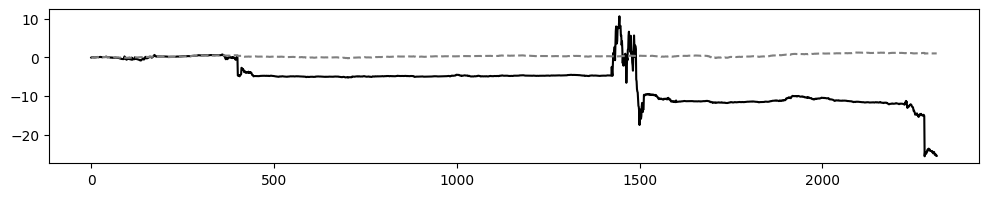

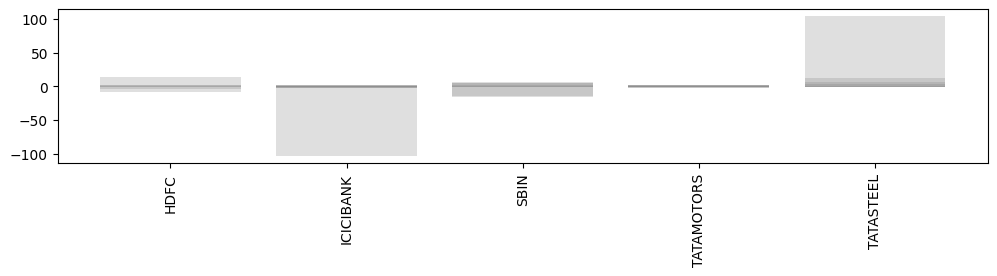

Episode 1/50 epsilon 1
1/1 [==============================] - 0s 32ms/step


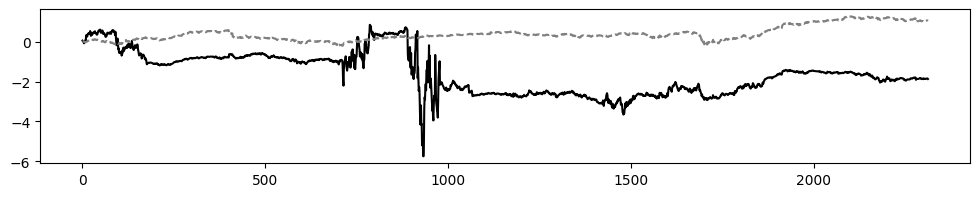

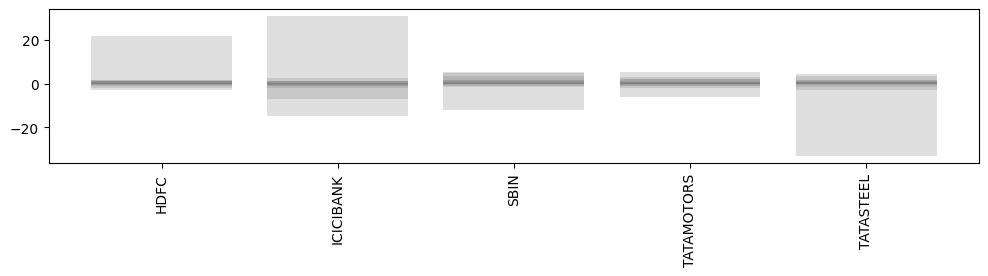

Episode 2/50 epsilon 0.99
1/1 [==============================] - 0s 26ms/step


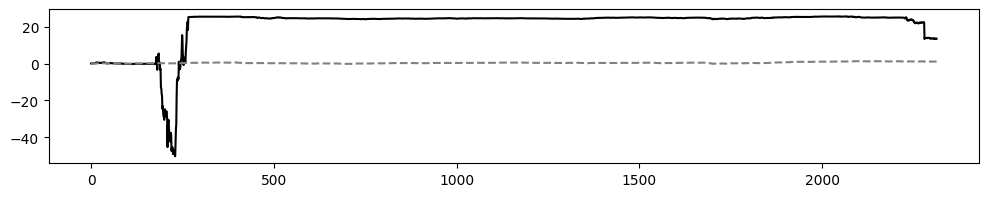

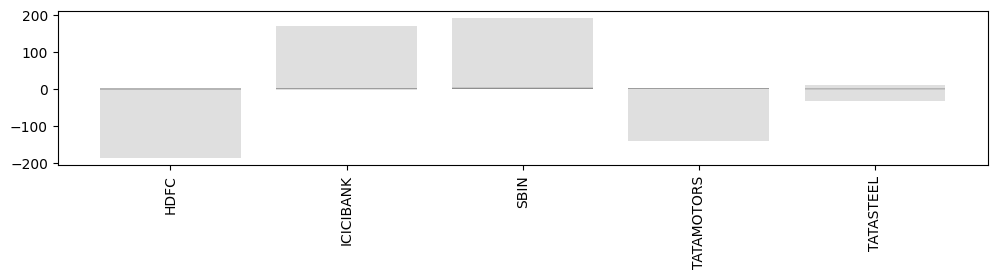

Episode 3/50 epsilon 0.9801
1/1 [==============================] - 0s 34ms/step


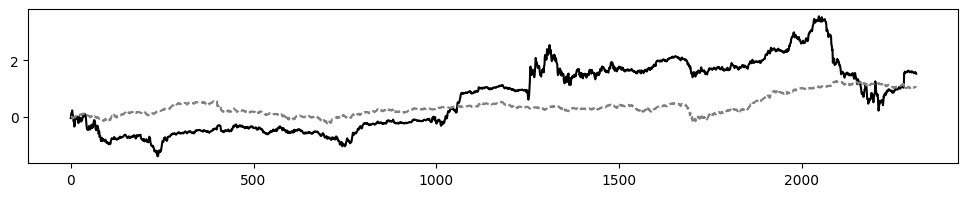

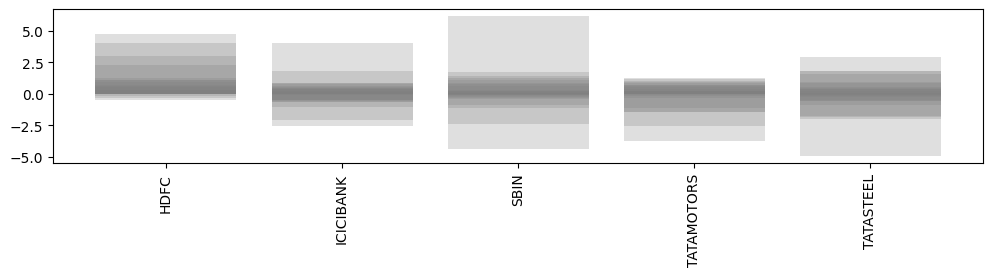

Episode 4/50 epsilon 0.9702989999999999
1/1 [==============================] - 0s 20ms/step


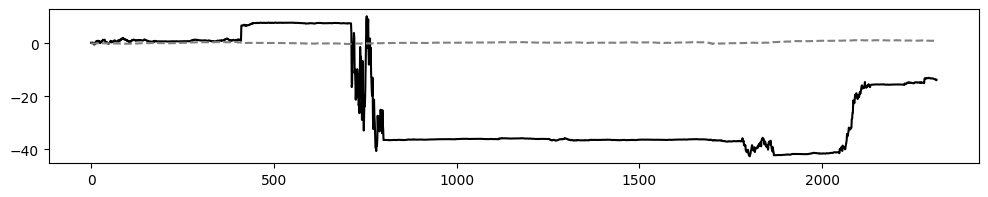

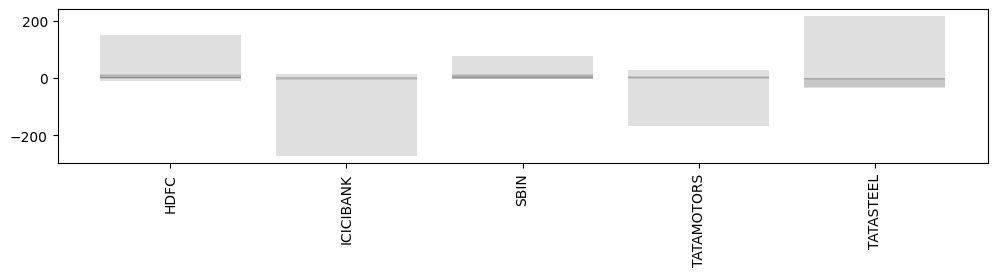

Episode 5/50 epsilon 0.96059601


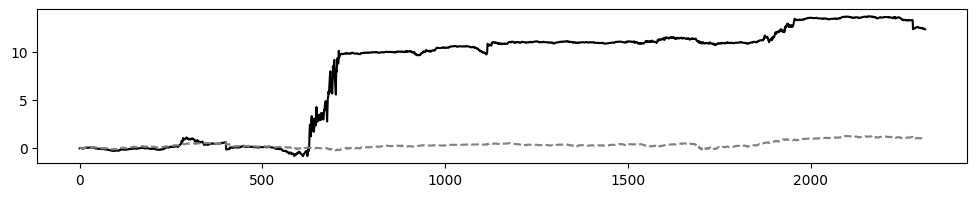

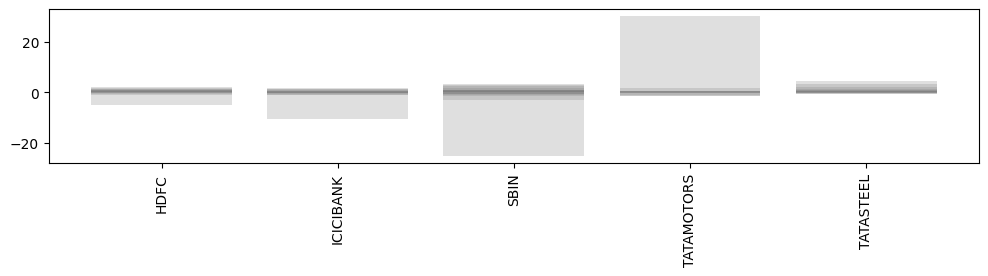

Episode 6/50 epsilon 0.96059601
1/1 [==============================] - 0s 91ms/step


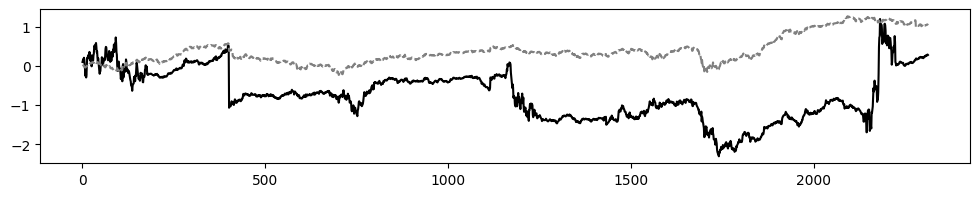

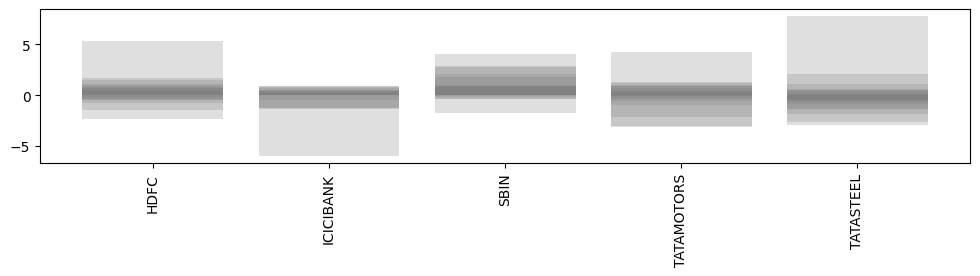

Episode 7/50 epsilon 0.9509900498999999
1/1 [==============================] - 0s 31ms/step


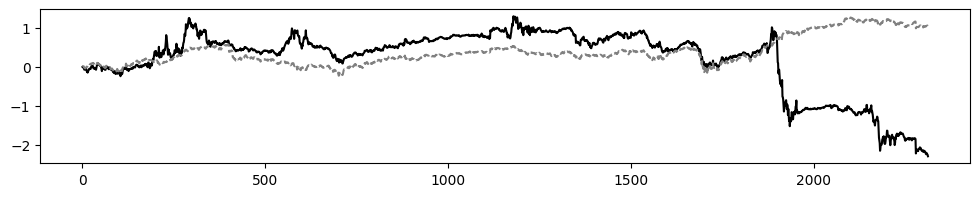

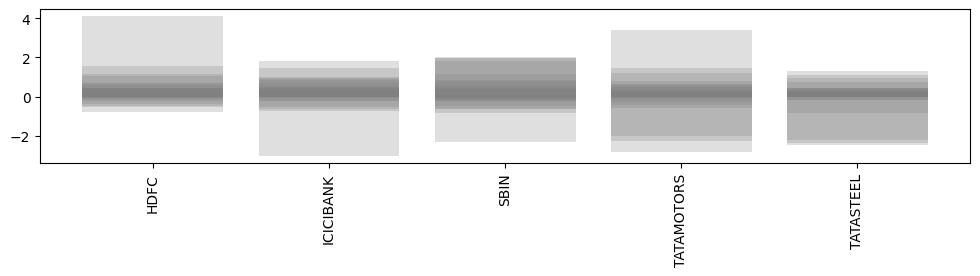

Episode 8/50 epsilon 0.9414801494009999
1/1 [==============================] - 0s 20ms/step


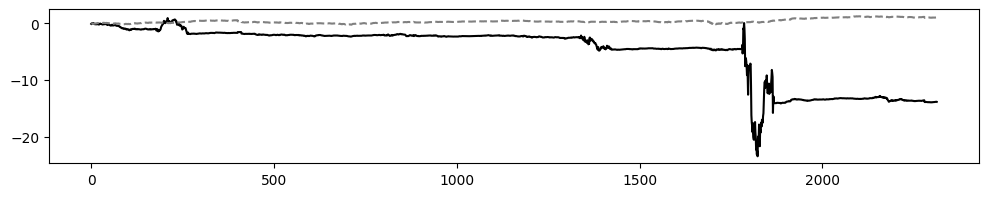

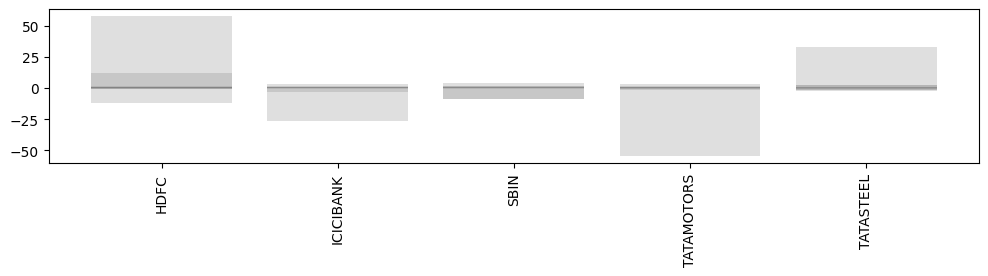

Episode 9/50 epsilon 0.9320653479069899
1/1 [==============================] - 0s 30ms/step


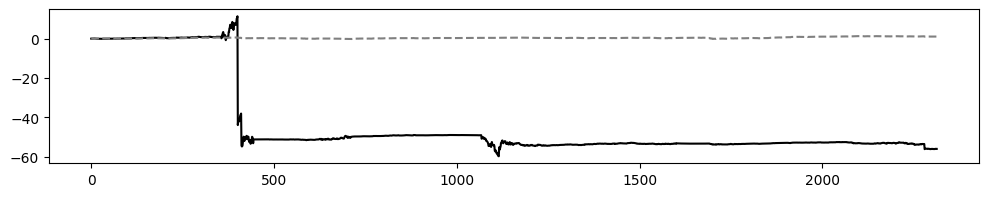

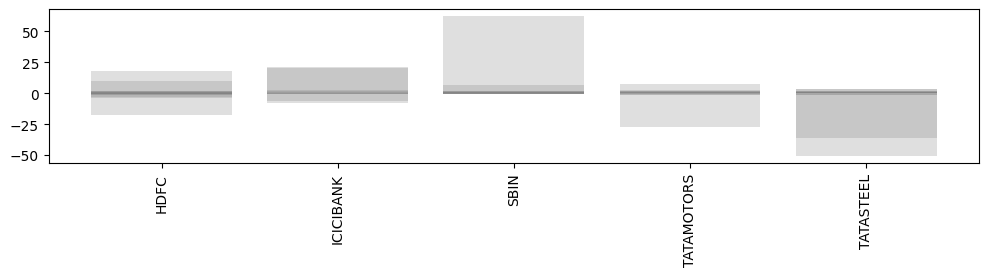

Episode 10/50 epsilon 0.92274469442792
1/1 [==============================] - 0s 30ms/step


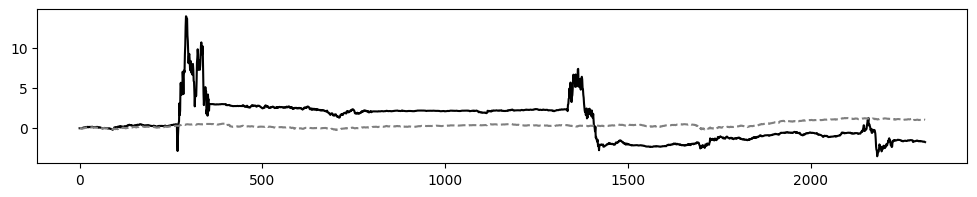

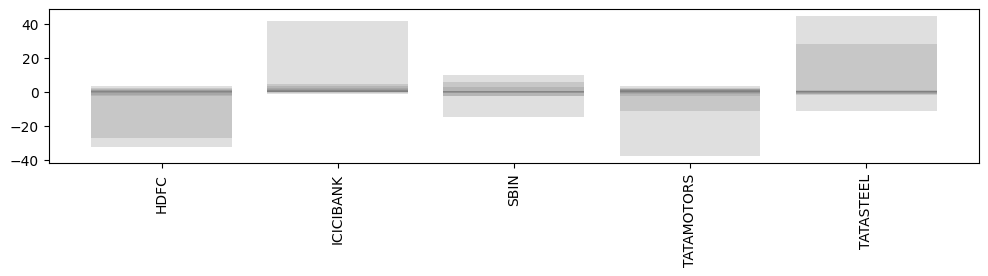

Episode 11/50 epsilon 0.92274469442792
1/1 [==============================] - 0s 22ms/step


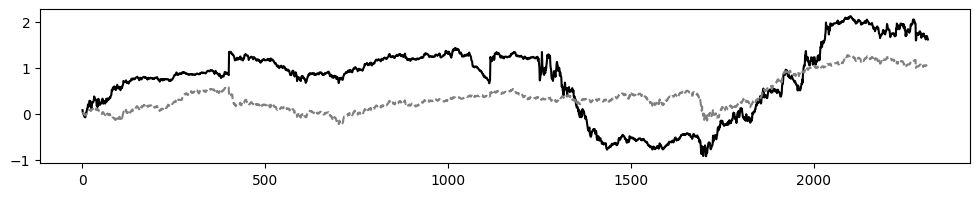

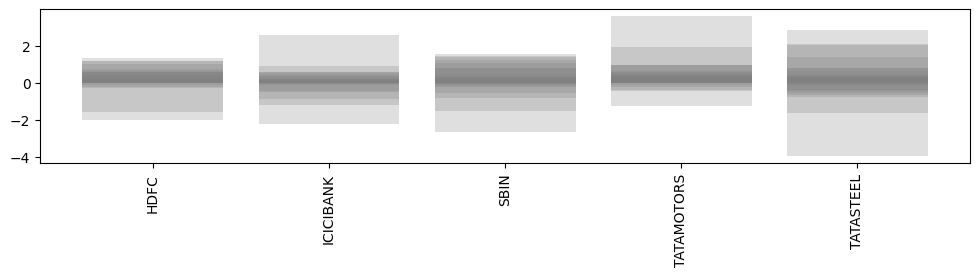

Episode 12/50 epsilon 0.9135172474836407
1/1 [==============================] - 0s 22ms/step


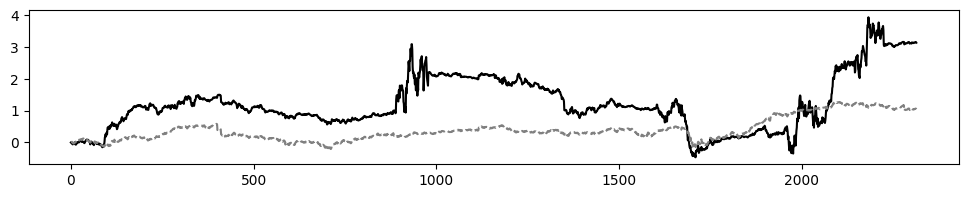

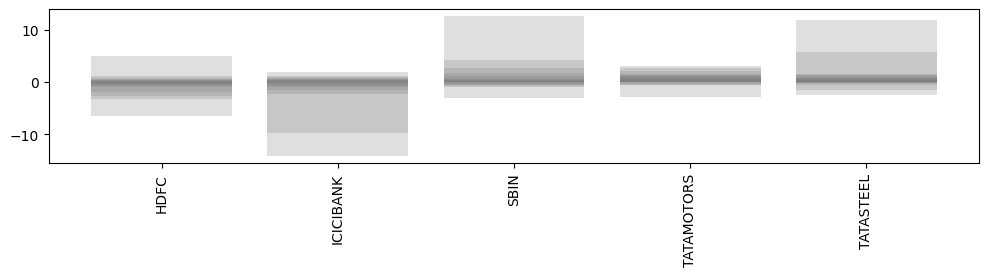

Episode 13/50 epsilon 0.9043820750088043
1/1 [==============================] - 0s 21ms/step


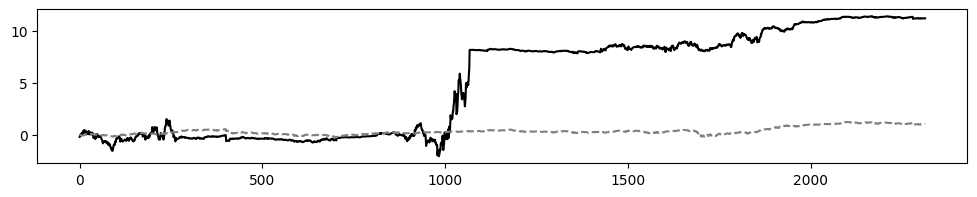

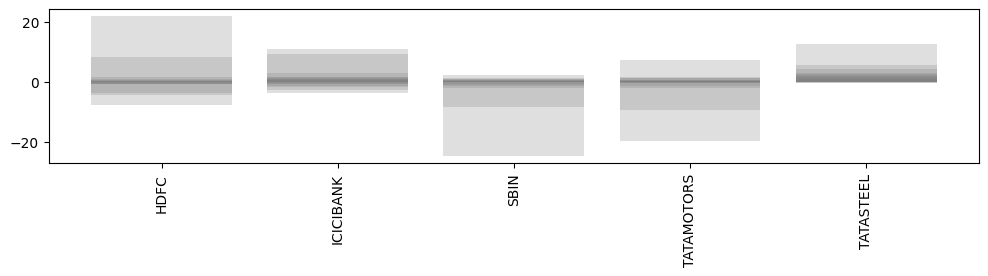

Episode 14/50 epsilon 0.8953382542587163
1/1 [==============================] - 0s 25ms/step


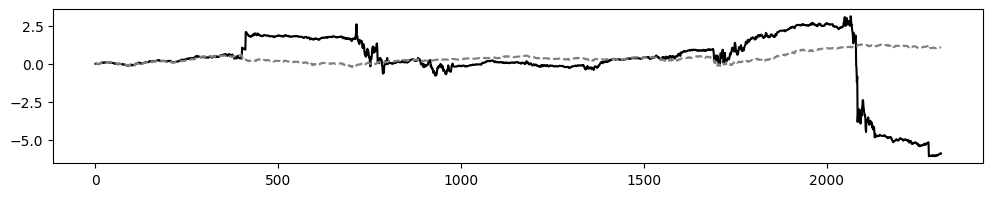

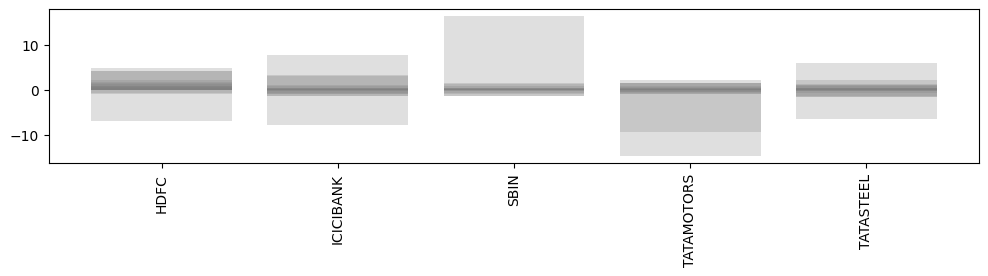

Episode 15/50 epsilon 0.8863848717161291
1/1 [==============================] - 0s 31ms/step


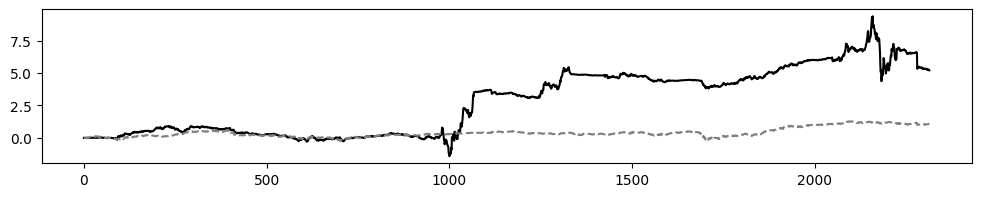

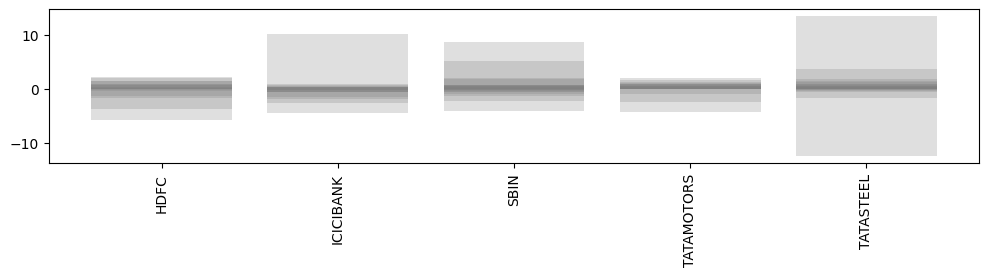

Episode 16/50 epsilon 0.8775210229989678
1/1 [==============================] - 0s 30ms/step


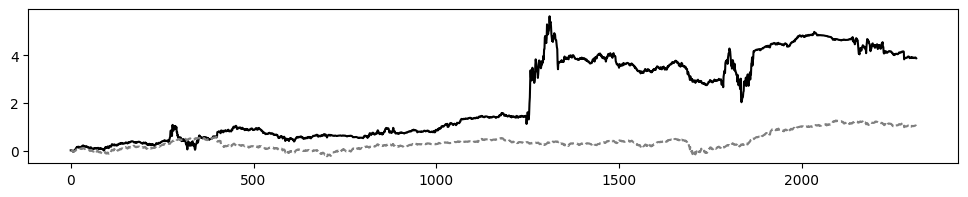

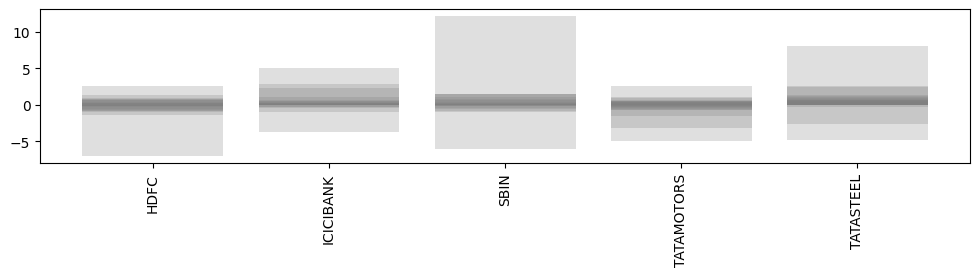

Episode 17/50 epsilon 0.8775210229989678
1/1 [==============================] - 0s 23ms/step


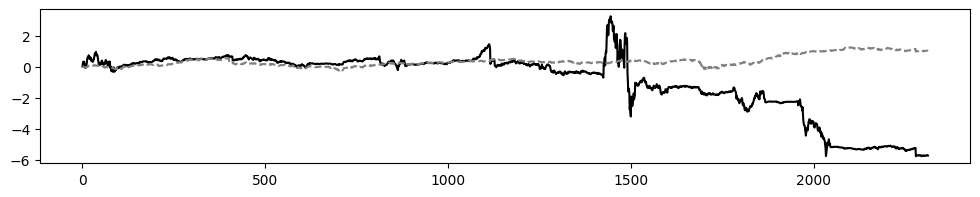

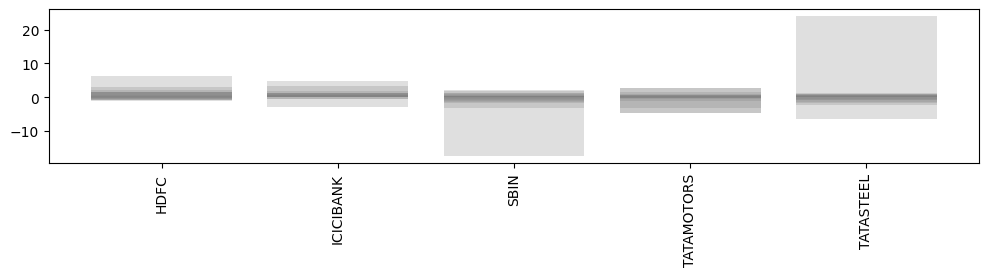

Episode 18/50 epsilon 0.8687458127689781
1/1 [==============================] - 0s 29ms/step


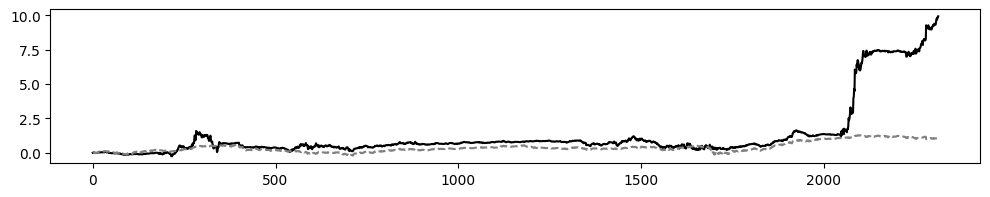

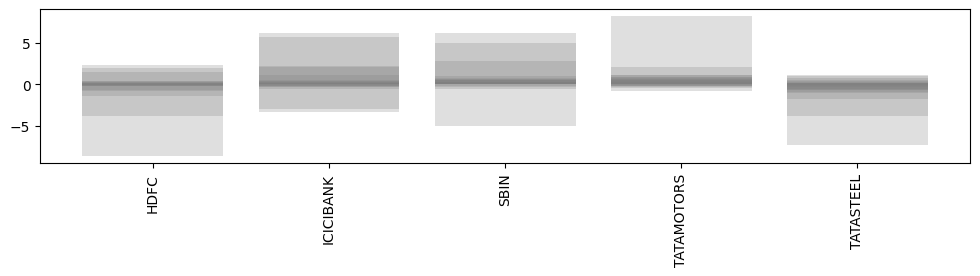

Episode 19/50 epsilon 0.8600583546412883
1/1 [==============================] - 0s 22ms/step


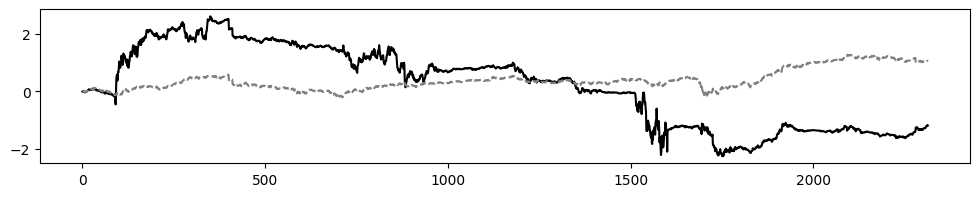

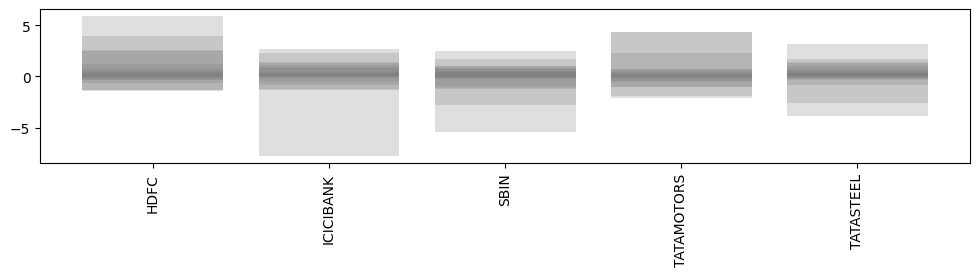

Episode 20/50 epsilon 0.8514577710948754
1/1 [==============================] - 0s 21ms/step


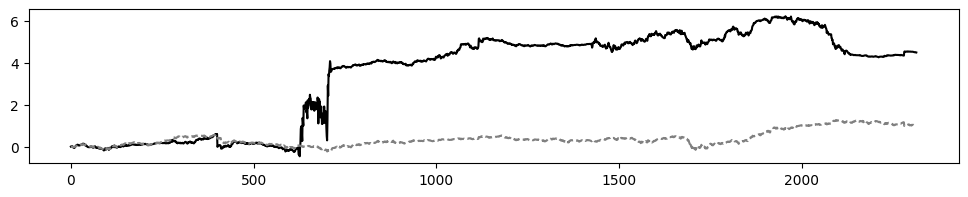

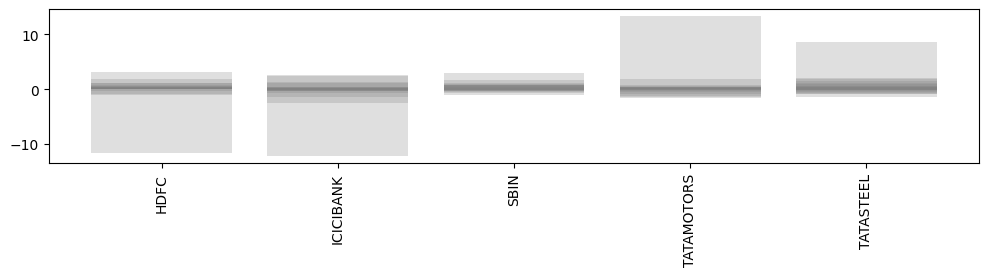

Episode 21/50 epsilon 0.8429431933839266
1/1 [==============================] - 0s 23ms/step


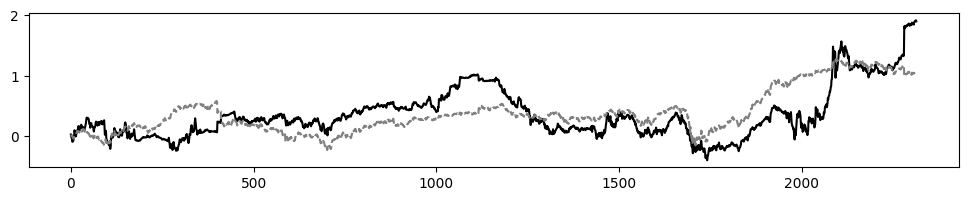

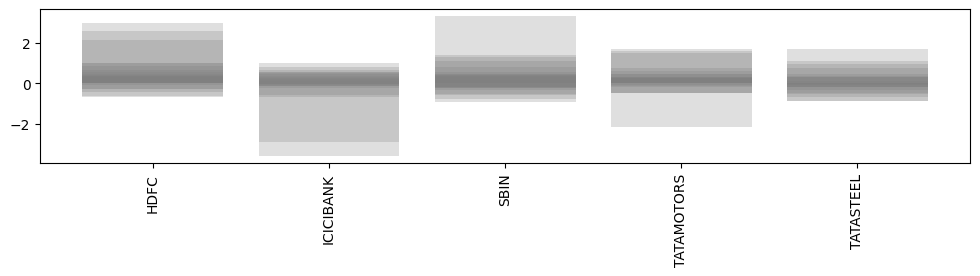

Episode 22/50 epsilon 0.8429431933839266
1/1 [==============================] - 0s 33ms/step


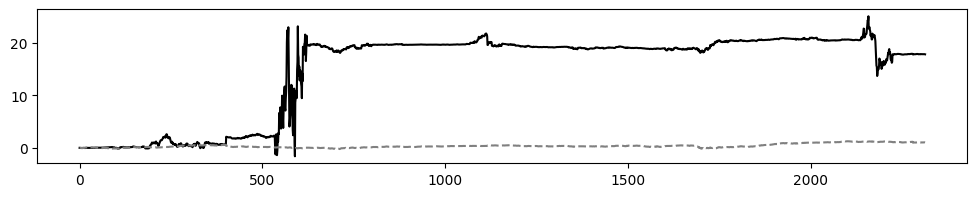

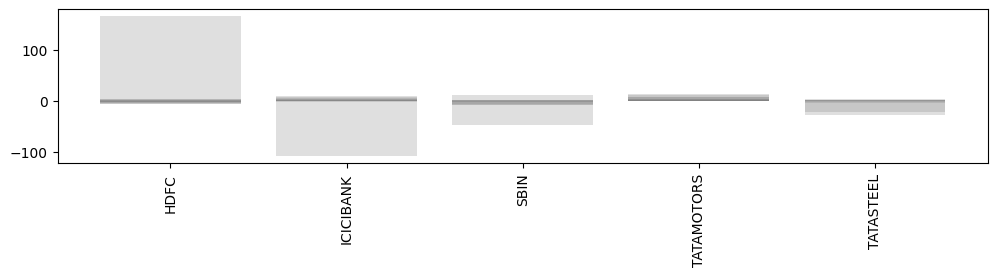

Episode 23/50 epsilon 0.8345137614500874
1/1 [==============================] - 0s 47ms/step


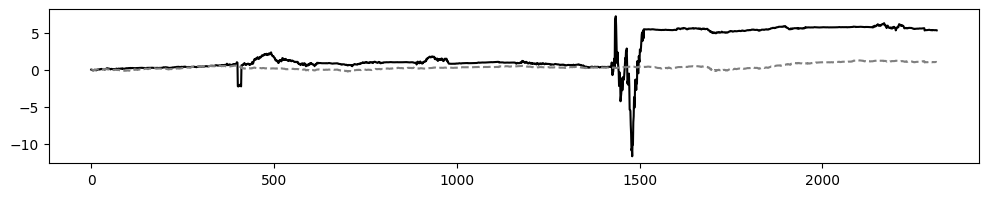

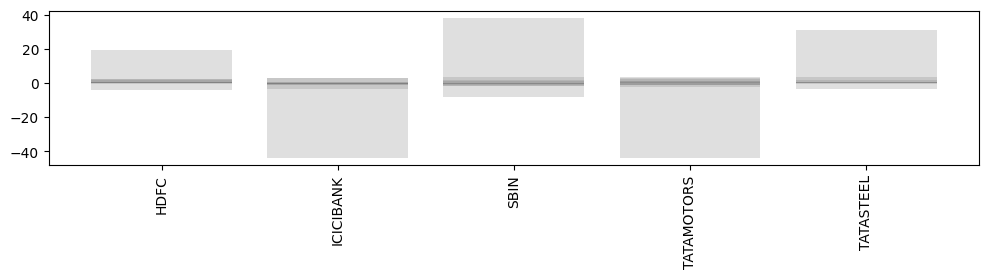

Episode 24/50 epsilon 0.8261686238355865
1/1 [==============================] - 0s 20ms/step


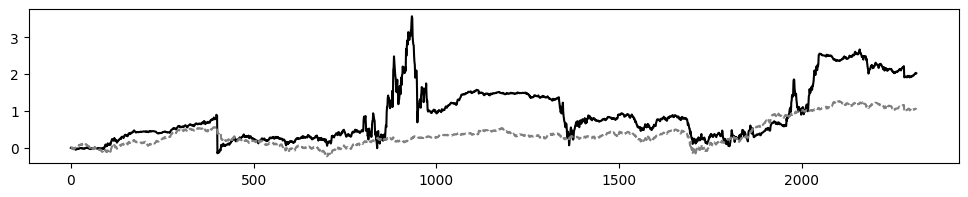

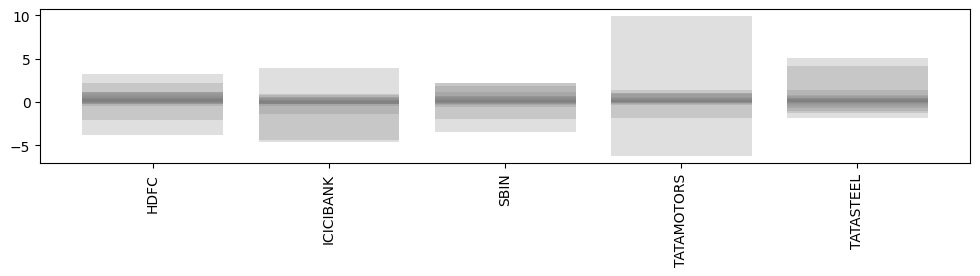

Episode 25/50 epsilon 0.8179069375972307
1/1 [==============================] - 0s 29ms/step


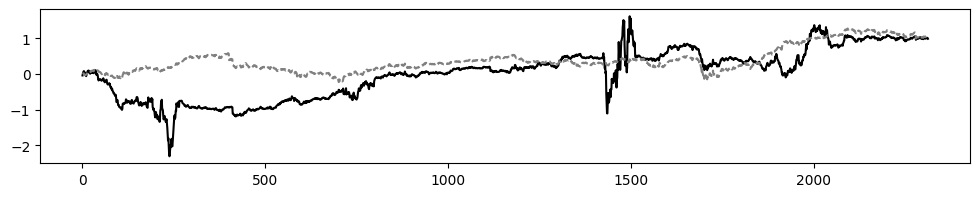

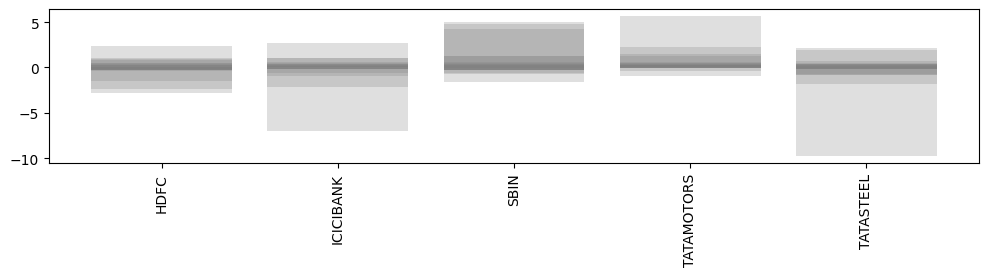

Episode 26/50 epsilon 0.8097278682212583
1/1 [==============================] - 0s 29ms/step


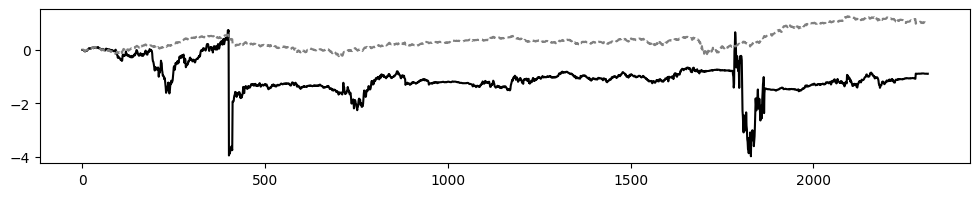

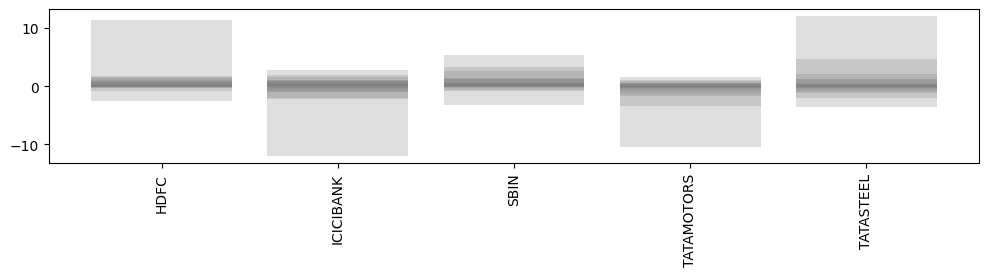

Episode 27/50 epsilon 0.8097278682212583
1/1 [==============================] - 0s 40ms/step


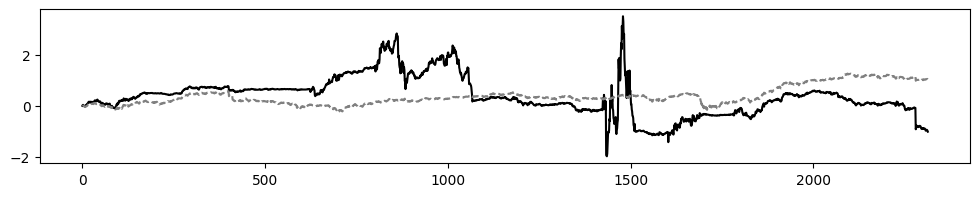

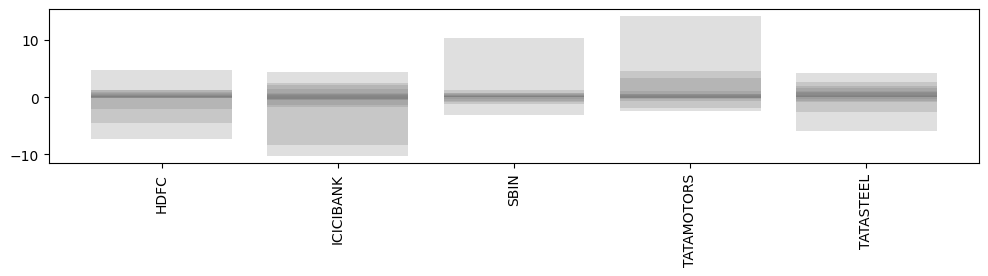

Episode 28/50 epsilon 0.8016305895390458
1/1 [==============================] - 0s 26ms/step


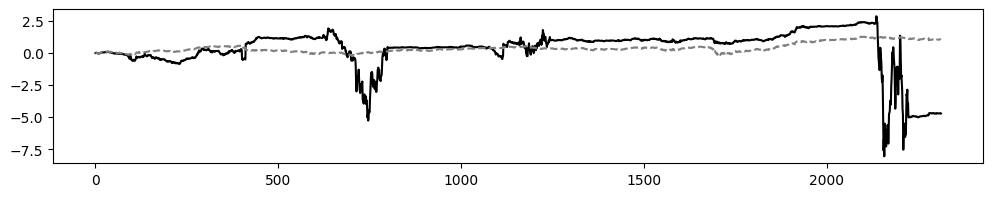

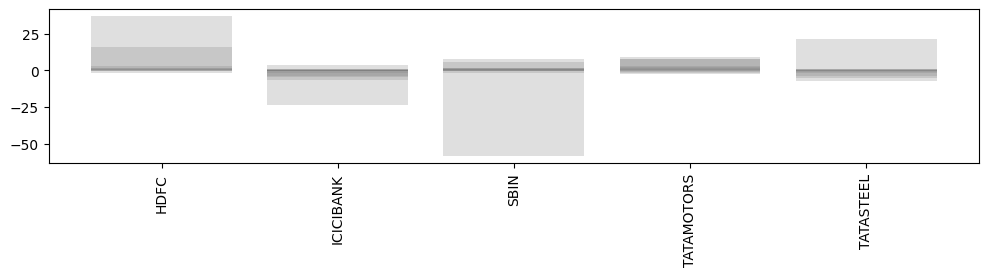

Episode 29/50 epsilon 0.7936142836436553
1/1 [==============================] - 0s 24ms/step


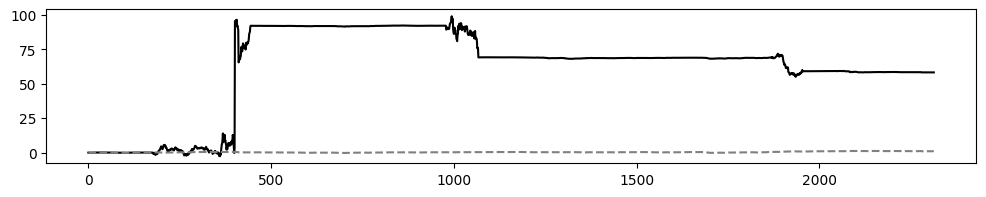

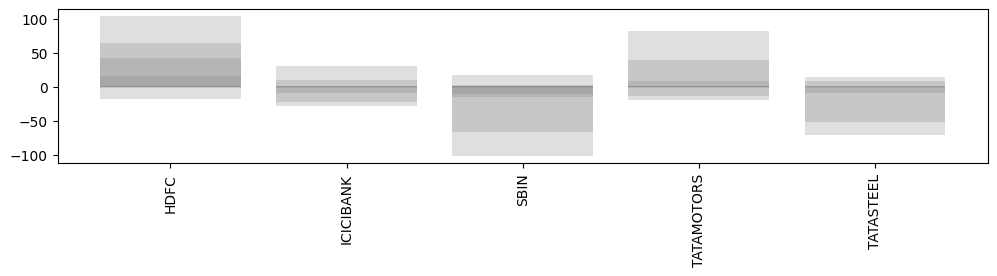

Episode 30/50 epsilon 0.7856781408072188
1/1 [==============================] - 0s 37ms/step


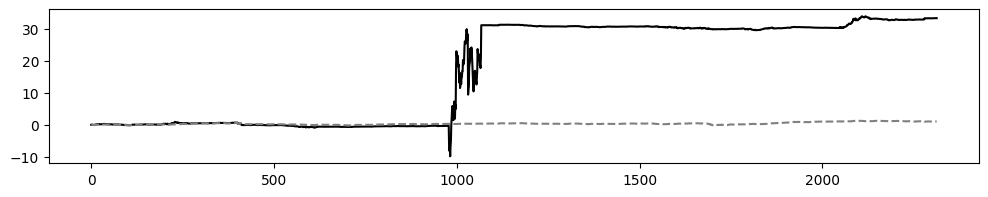

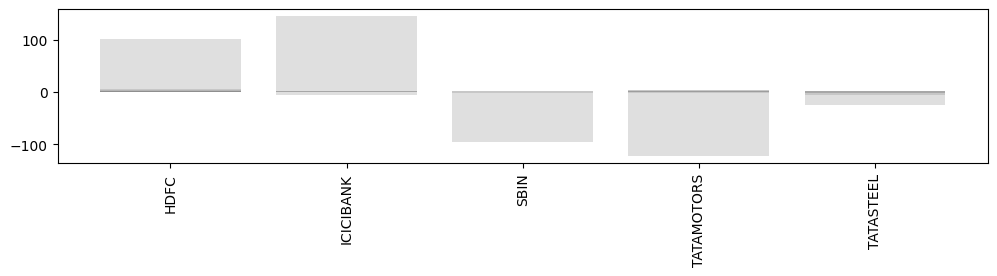

Episode 31/50 epsilon 0.7778213593991465
1/1 [==============================] - 0s 20ms/step


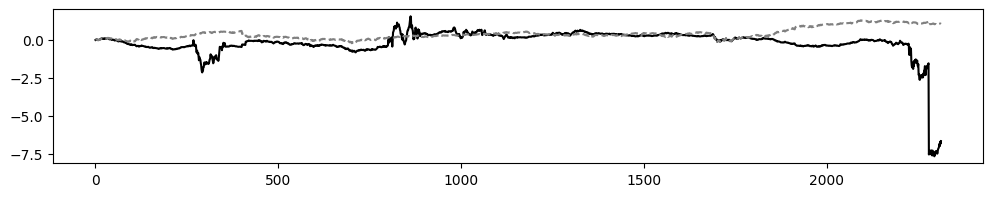

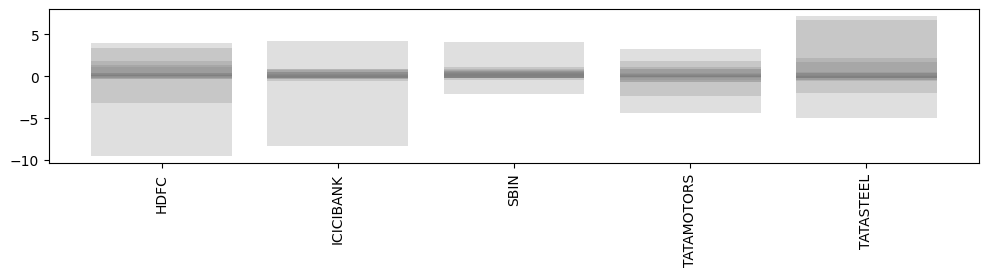

Episode 32/50 epsilon 0.7700431458051551
1/1 [==============================] - 0s 21ms/step


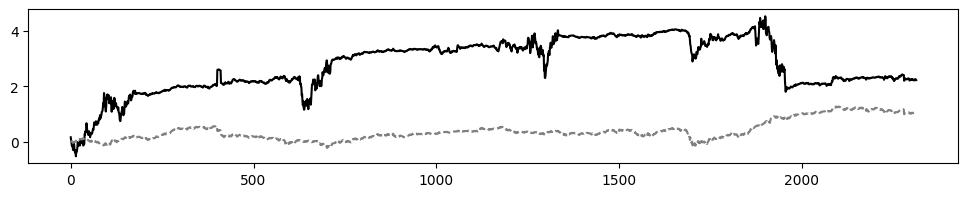

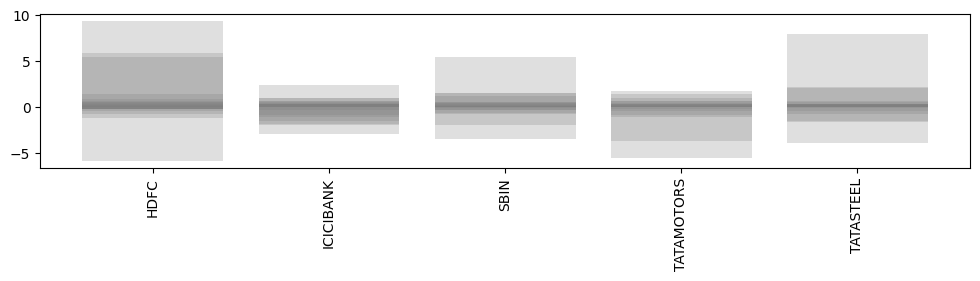

Episode 33/50 epsilon 0.7700431458051551
1/1 [==============================] - 0s 29ms/step


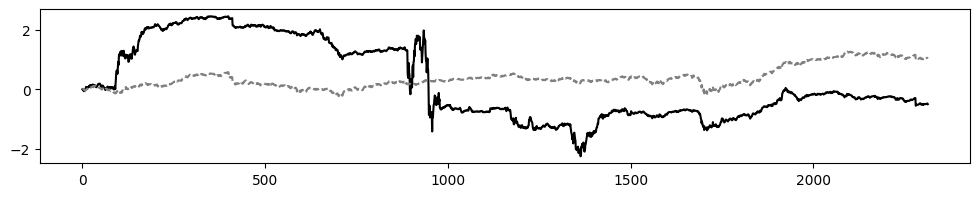

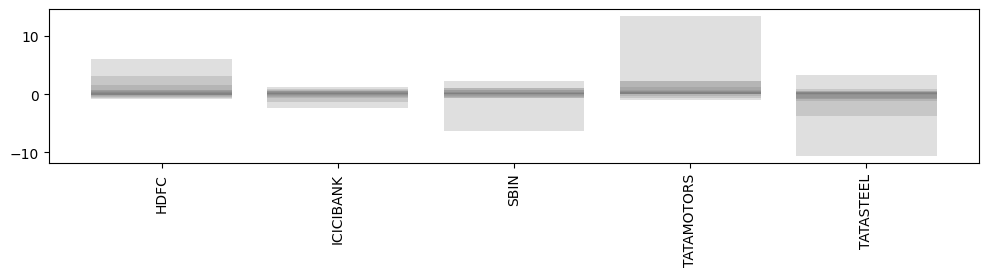

Episode 34/50 epsilon 0.7623427143471035
1/1 [==============================] - 0s 26ms/step


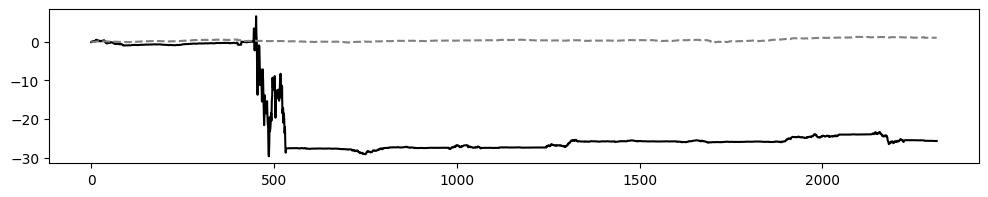

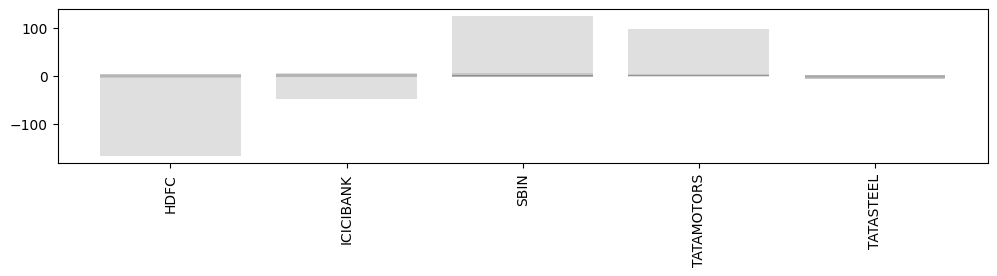

Episode 35/50 epsilon 0.7547192872036325
1/1 [==============================] - 0s 24ms/step


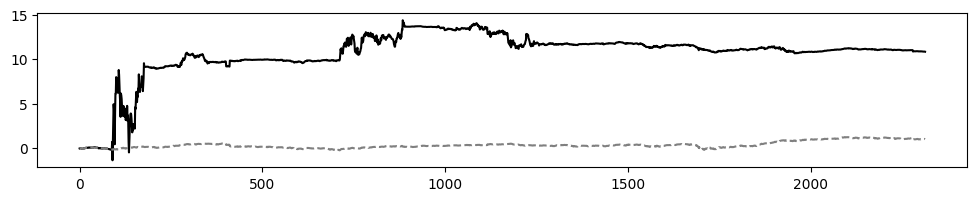

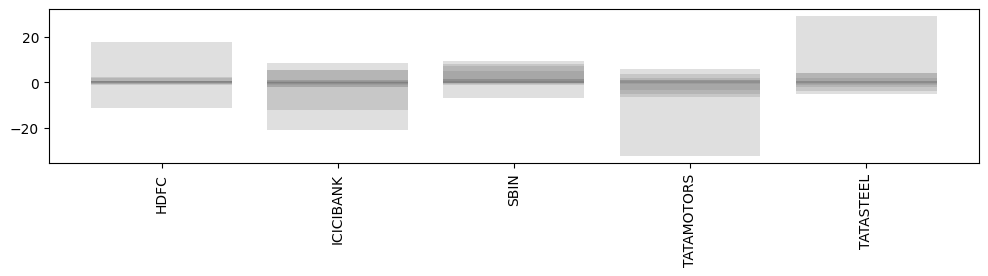

Episode 36/50 epsilon 0.7471720943315961
1/1 [==============================] - 0s 67ms/step


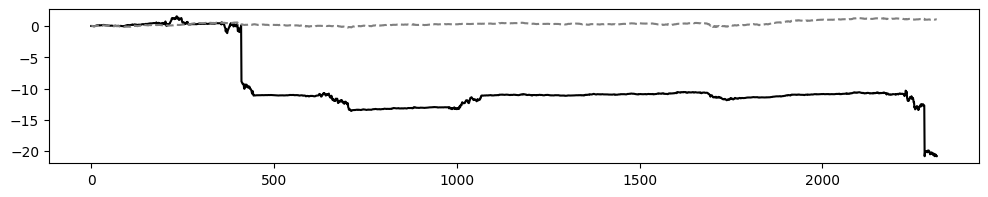

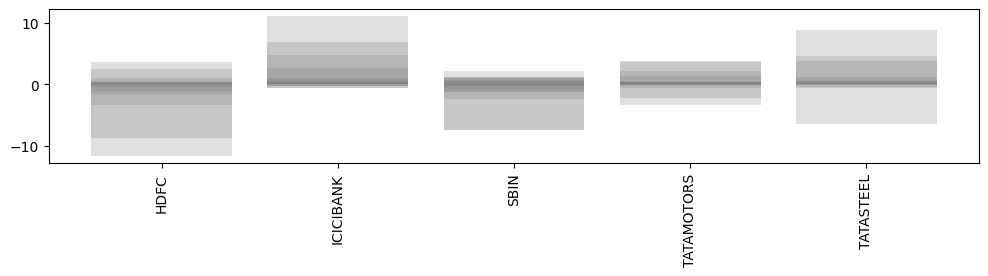

Episode 37/50 epsilon 0.7397003733882802
1/1 [==============================] - 0s 47ms/step


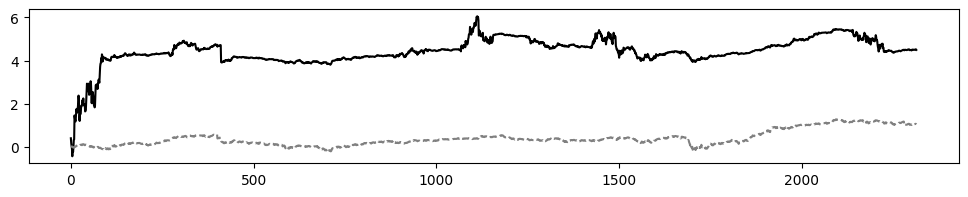

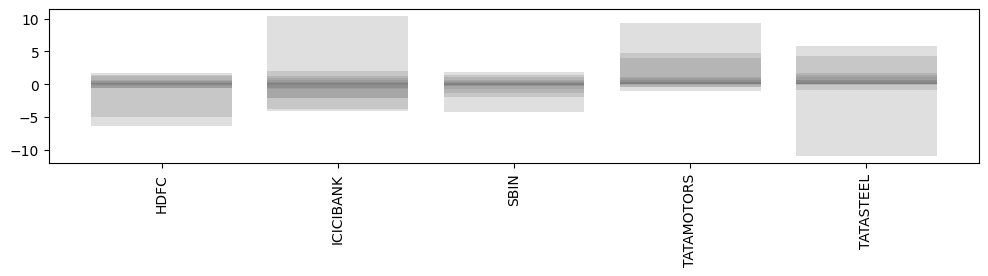

Episode 38/50 epsilon 0.7397003733882802
1/1 [==============================] - 0s 22ms/step


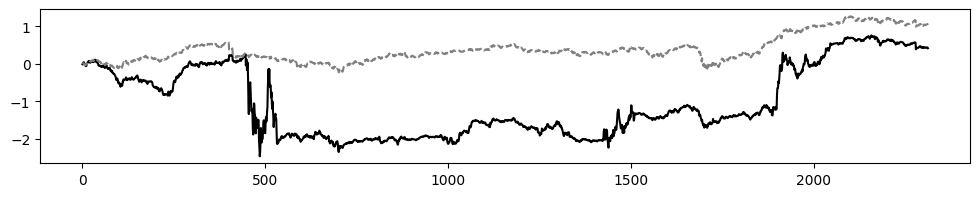

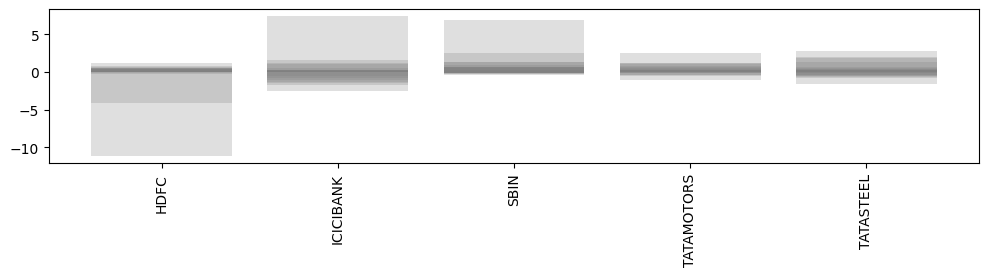

Episode 39/50 epsilon 0.7323033696543974
1/1 [==============================] - 0s 30ms/step


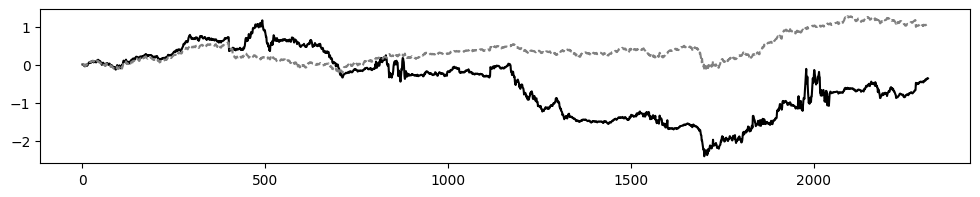

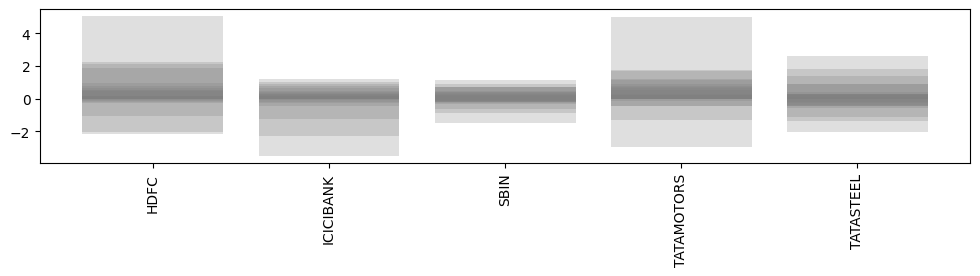

Episode 40/50 epsilon 0.7249803359578534
1/1 [==============================] - 0s 23ms/step


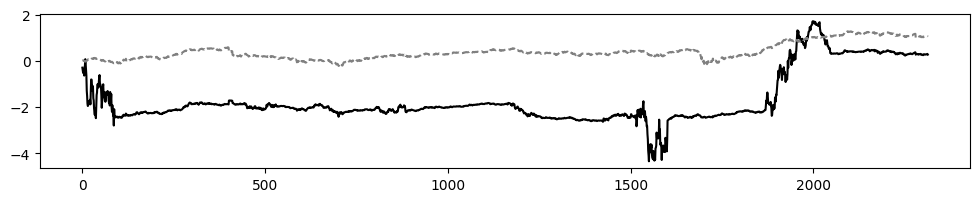

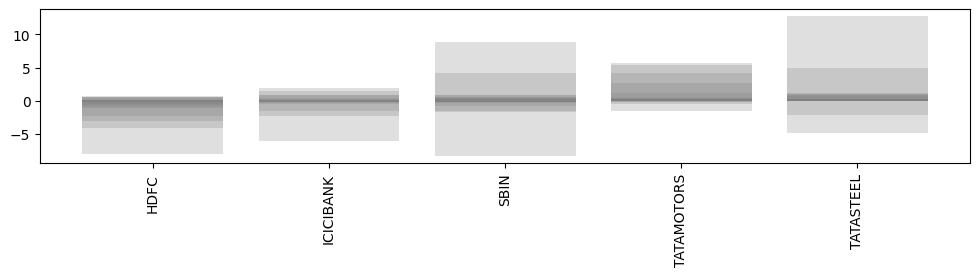

Episode 41/50 epsilon 0.7177305325982748
1/1 [==============================] - 0s 23ms/step


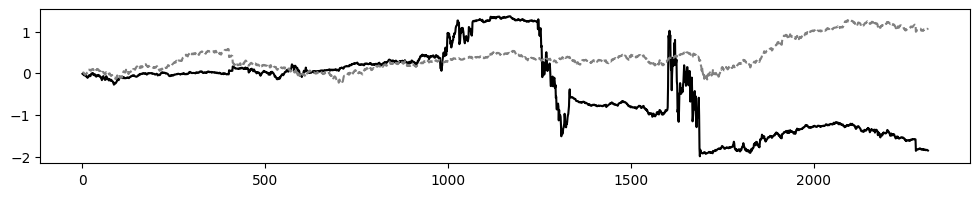

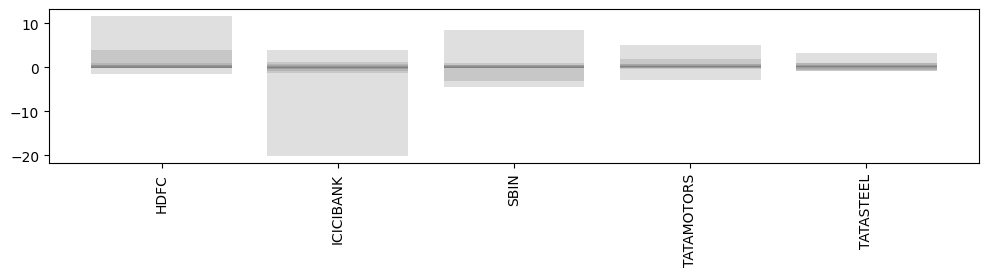

Episode 42/50 epsilon 0.7105532272722921
1/1 [==============================] - 0s 24ms/step


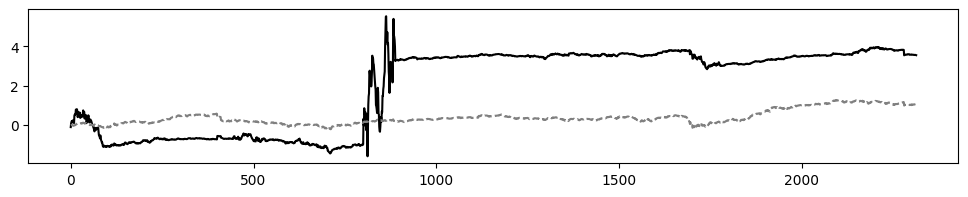

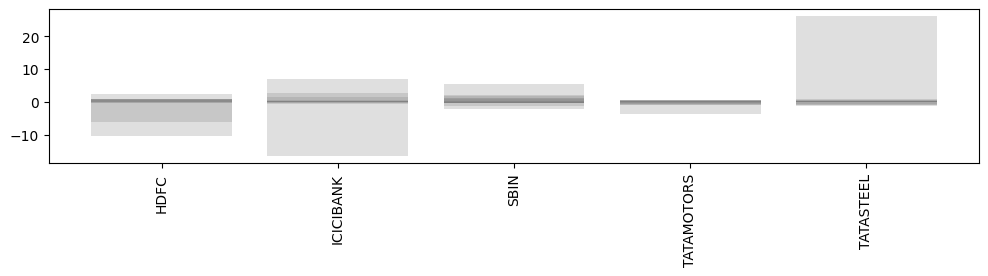

Episode 43/50 epsilon 0.7105532272722921
1/1 [==============================] - 0s 56ms/step


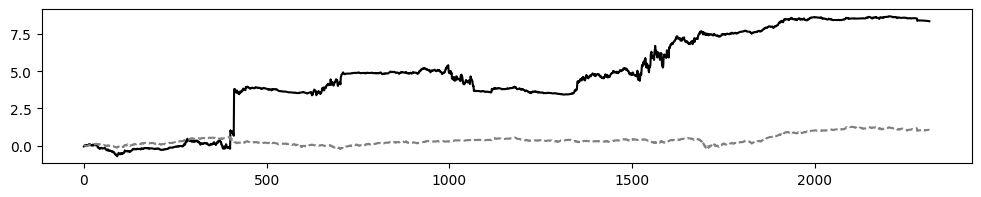

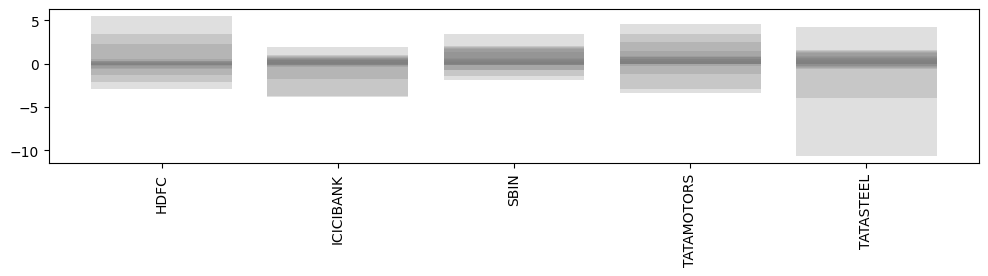

Episode 44/50 epsilon 0.7034476949995692
1/1 [==============================] - 0s 26ms/step


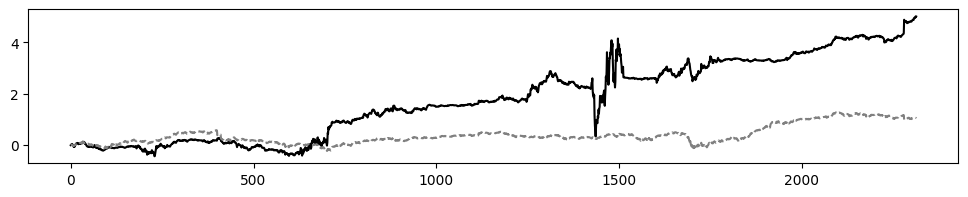

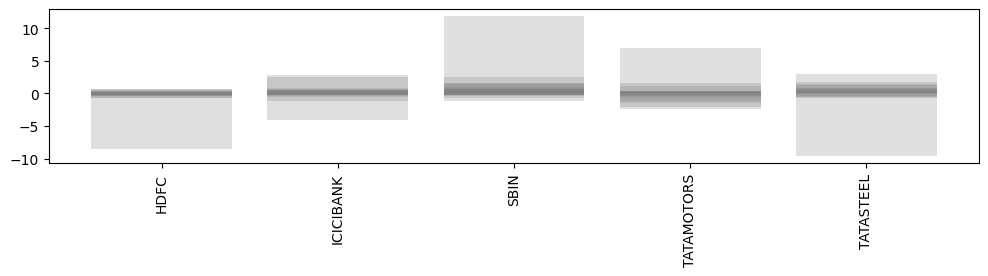

Episode 45/50 epsilon 0.6964132180495735
1/1 [==============================] - 0s 33ms/step


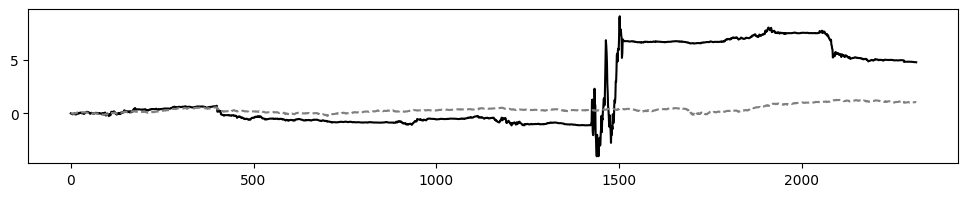

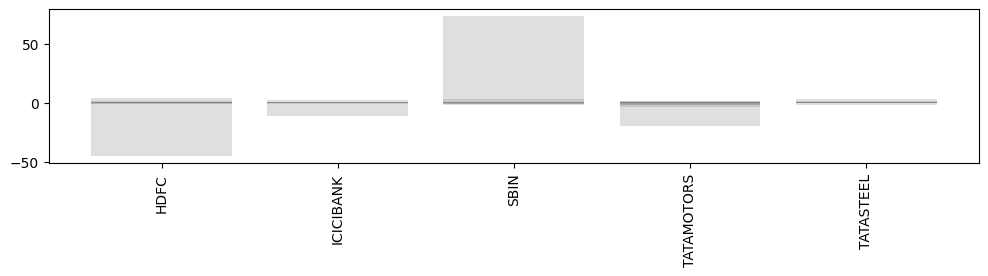

Episode 46/50 epsilon 0.6894490858690777
1/1 [==============================] - 0s 30ms/step


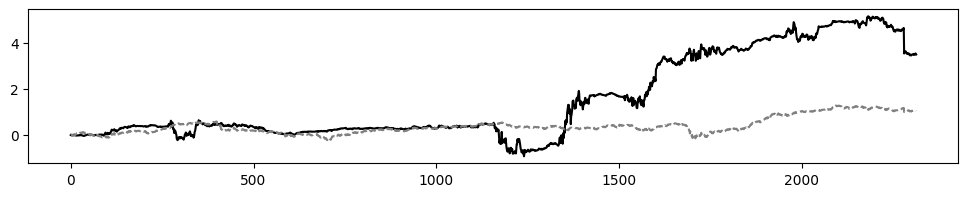

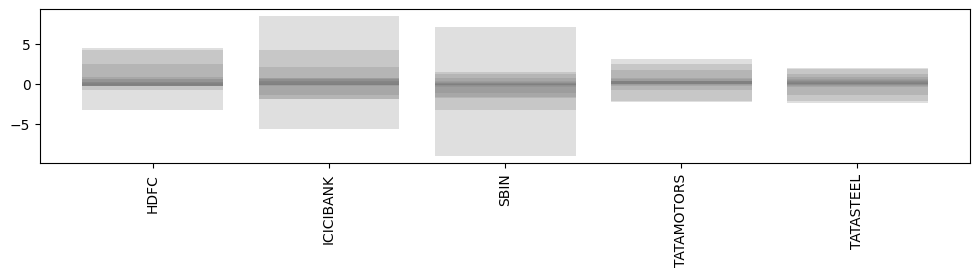

Episode 47/50 epsilon 0.682554595010387
1/1 [==============================] - 0s 26ms/step


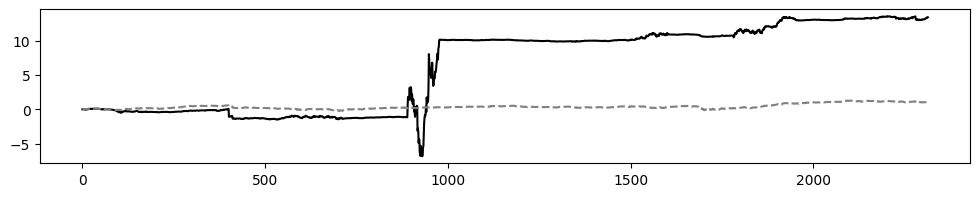

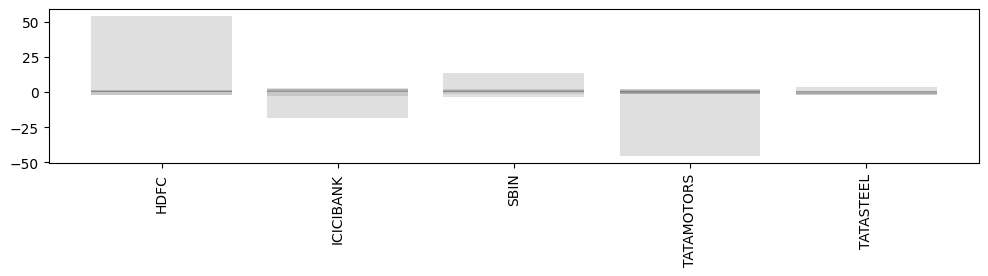

Episode 48/50 epsilon 0.6757290490602831
1/1 [==============================] - 0s 26ms/step


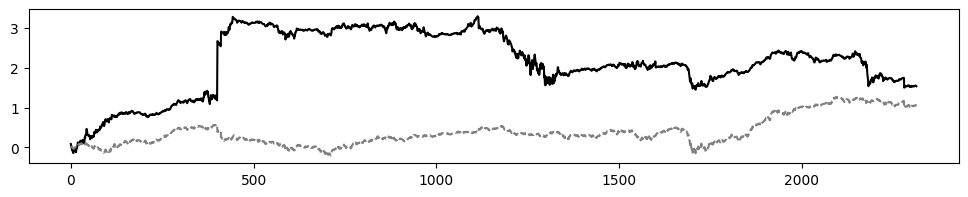

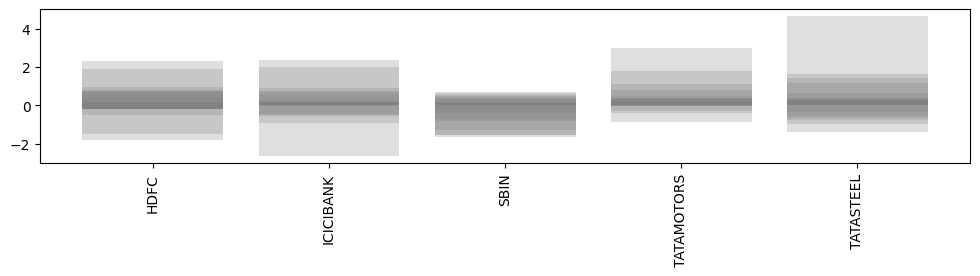

Episode 49/50 epsilon 0.6757290490602831
1/1 [==============================] - 0s 62ms/step


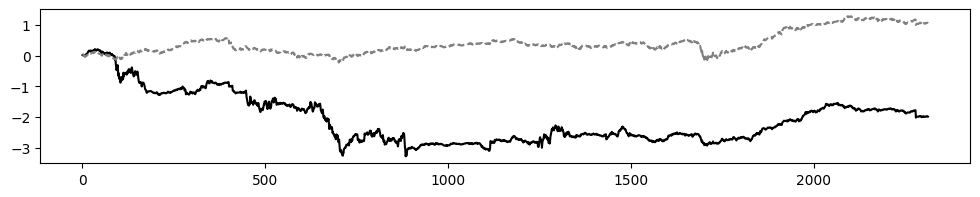

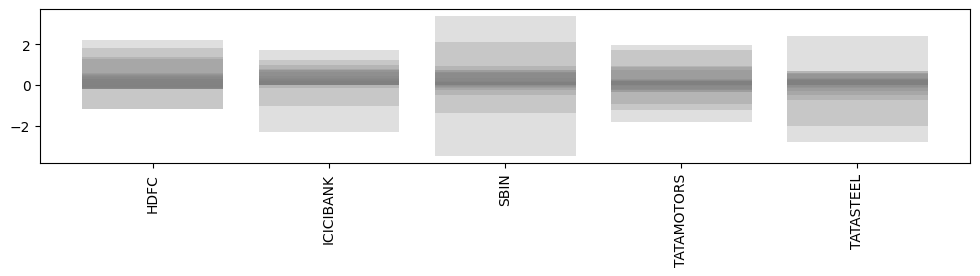

In [56]:
for e in range(episode_count):

    agent.is_eval = False
    data_length = len(env.data)

    returns_history = []
    returns_history_equal = []

    rewards_history = []
    equal_rewards = []

    actions_to_show = []

    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0

    for t in range(window_size, data_length, rebalance_period):
        date1 = t-rebalance_period
        #correlation from 90-180 days
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)

        actions_to_show.append(action[0])

        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))

        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []

        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()

    plt.figure(figsize = (12, 2))
    for a in actions_to_show:
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()

## 5. Testing the Data
After training the data, it is tested it against the test dataset.



1/1 [==============================] - 0s 23ms/step


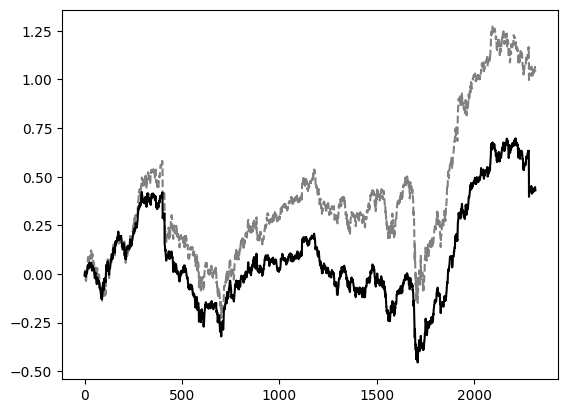

In [57]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)

    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'Benchmark', color = 'grey',ls = '--')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'Deep RL portfolio', color = 'black',ls = '-')
plt.show()

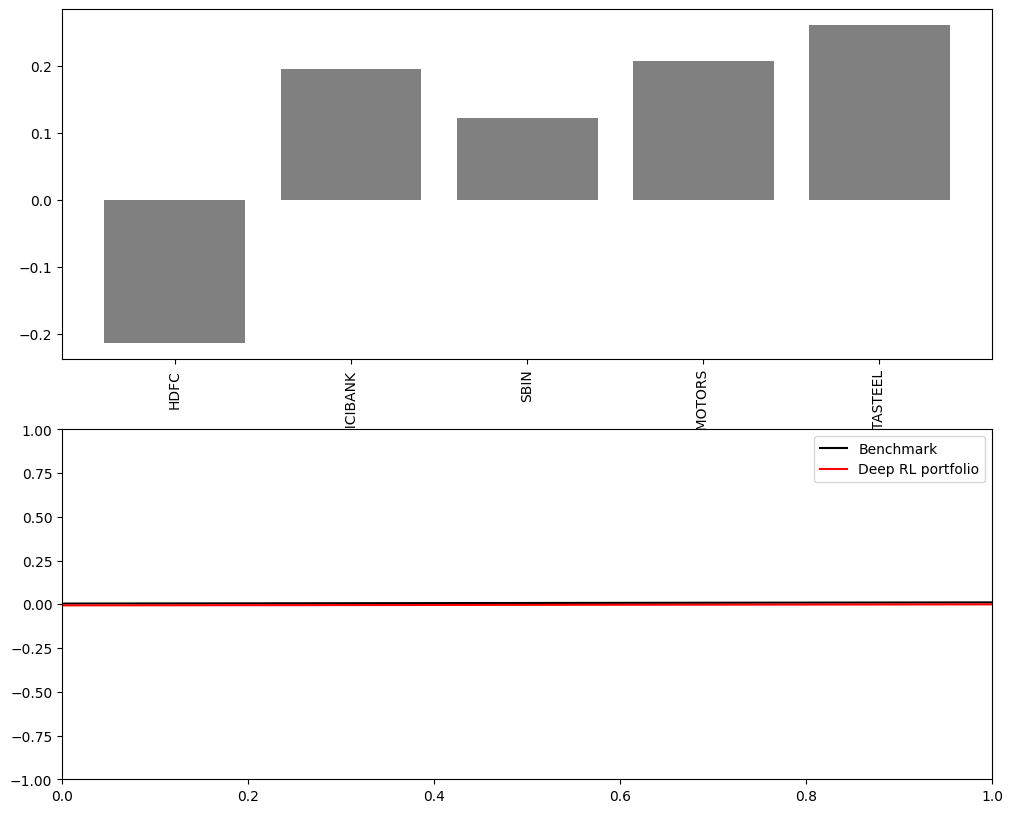

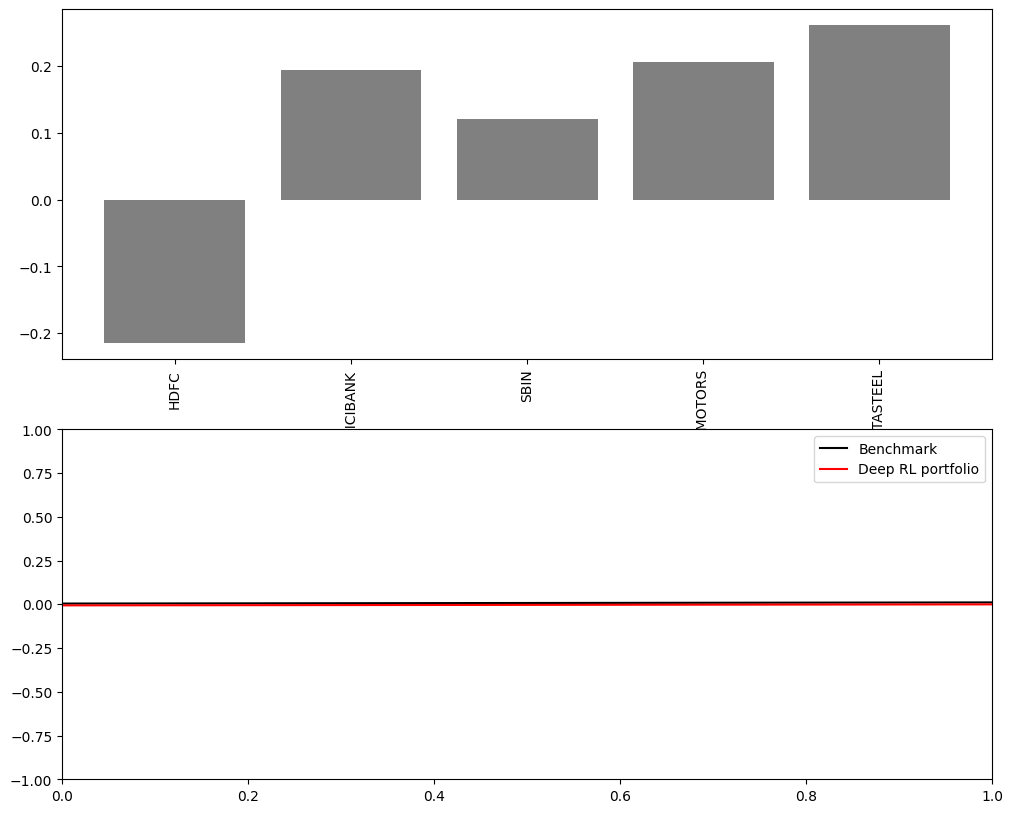

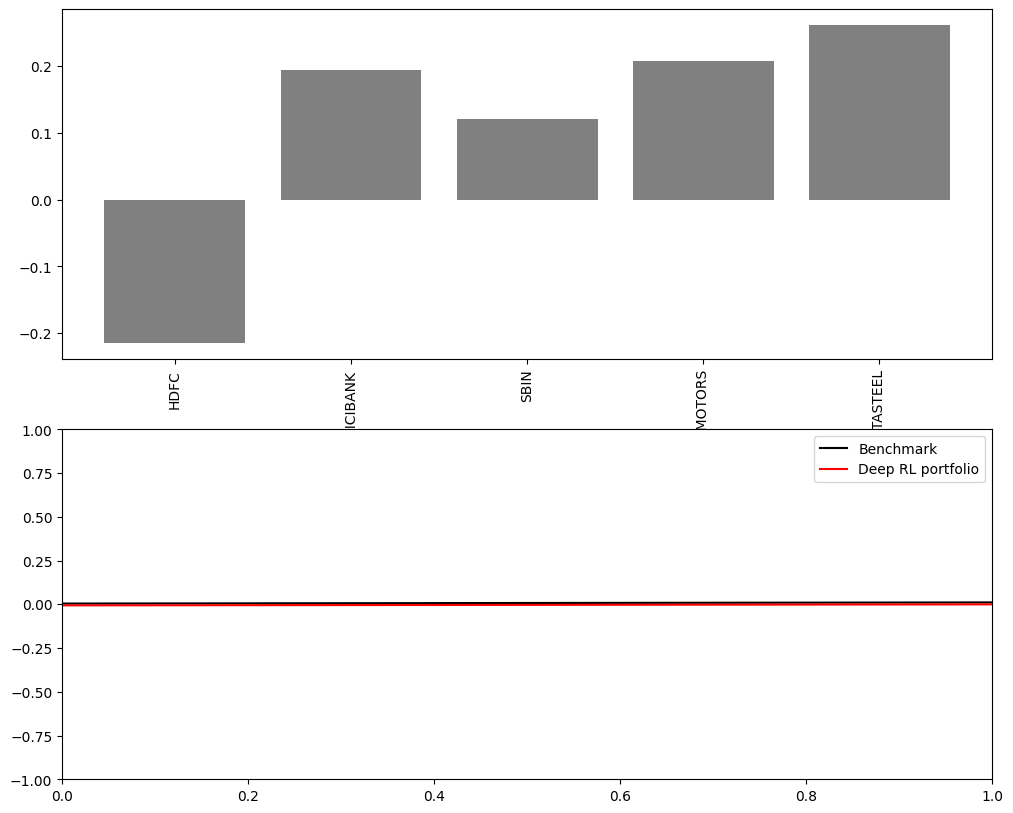

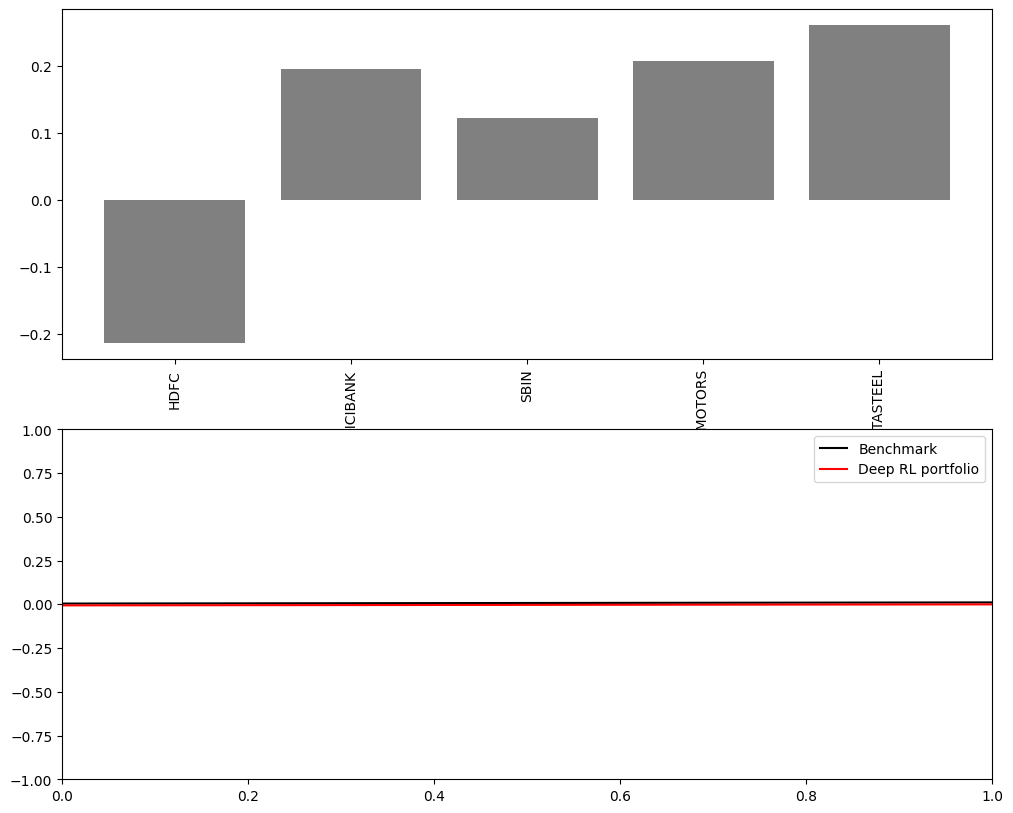

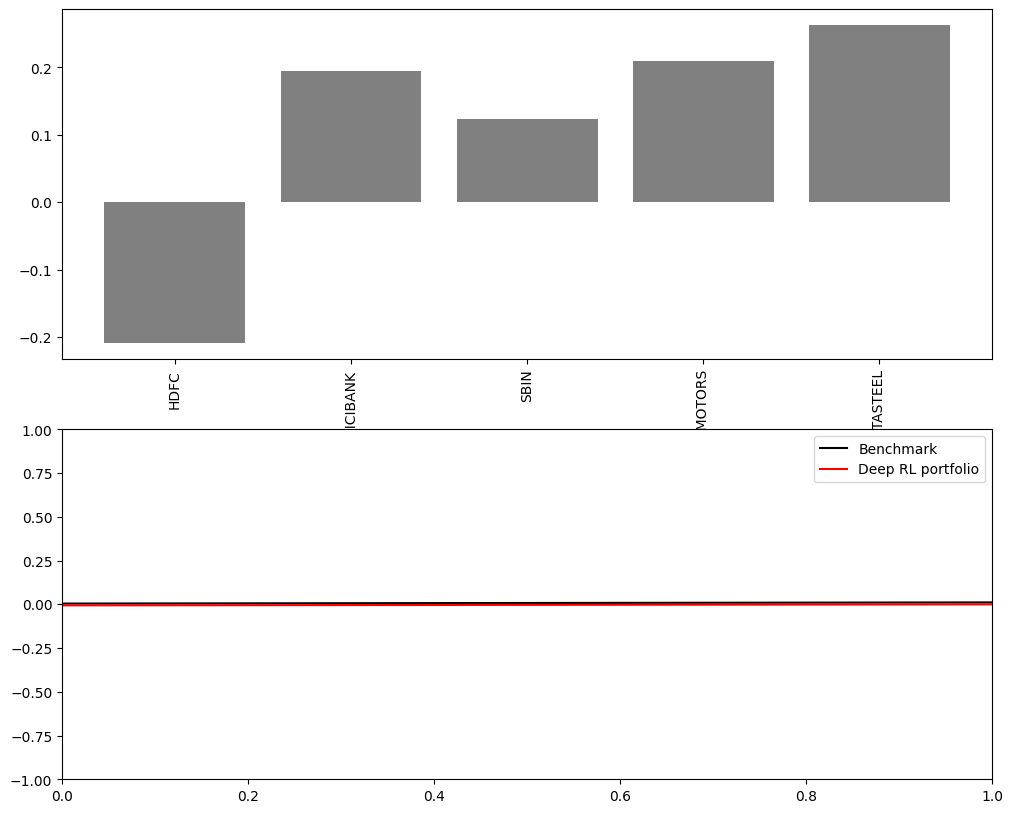

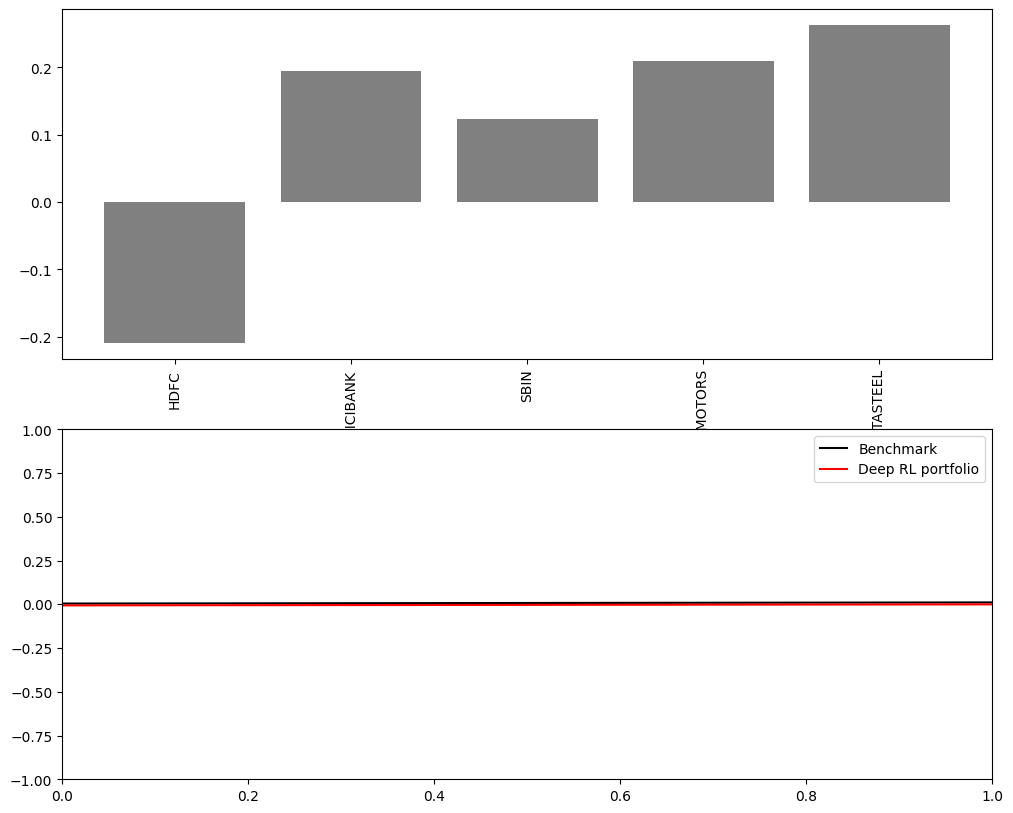

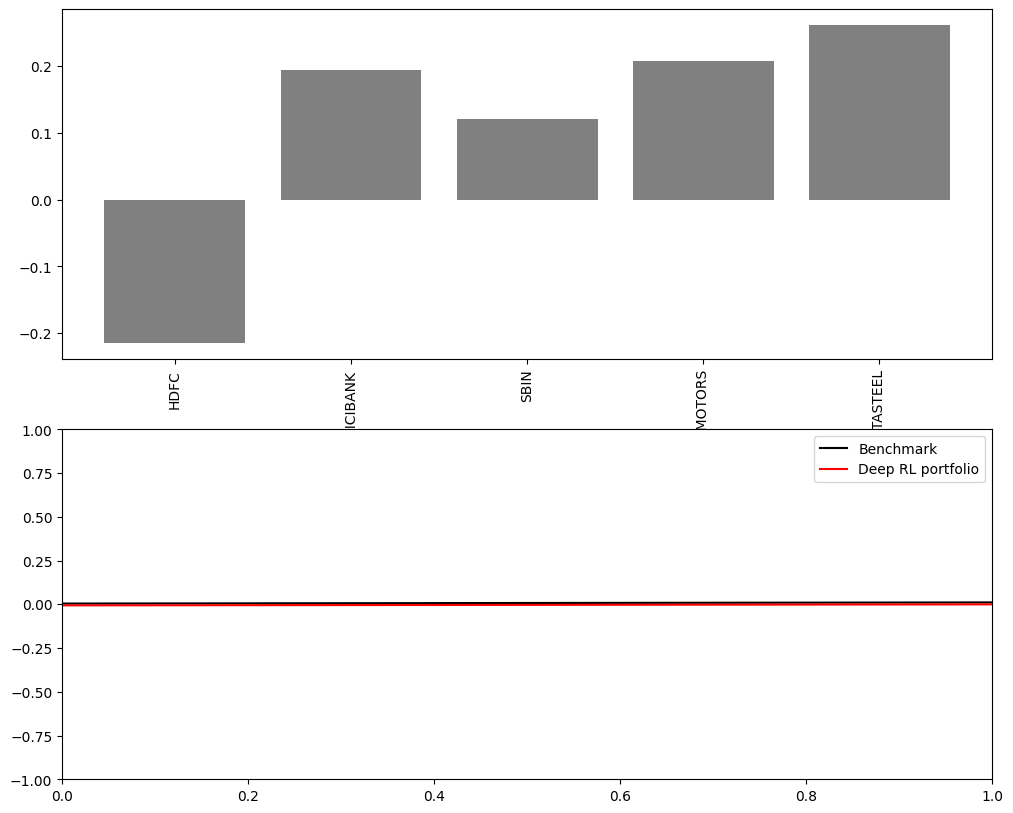

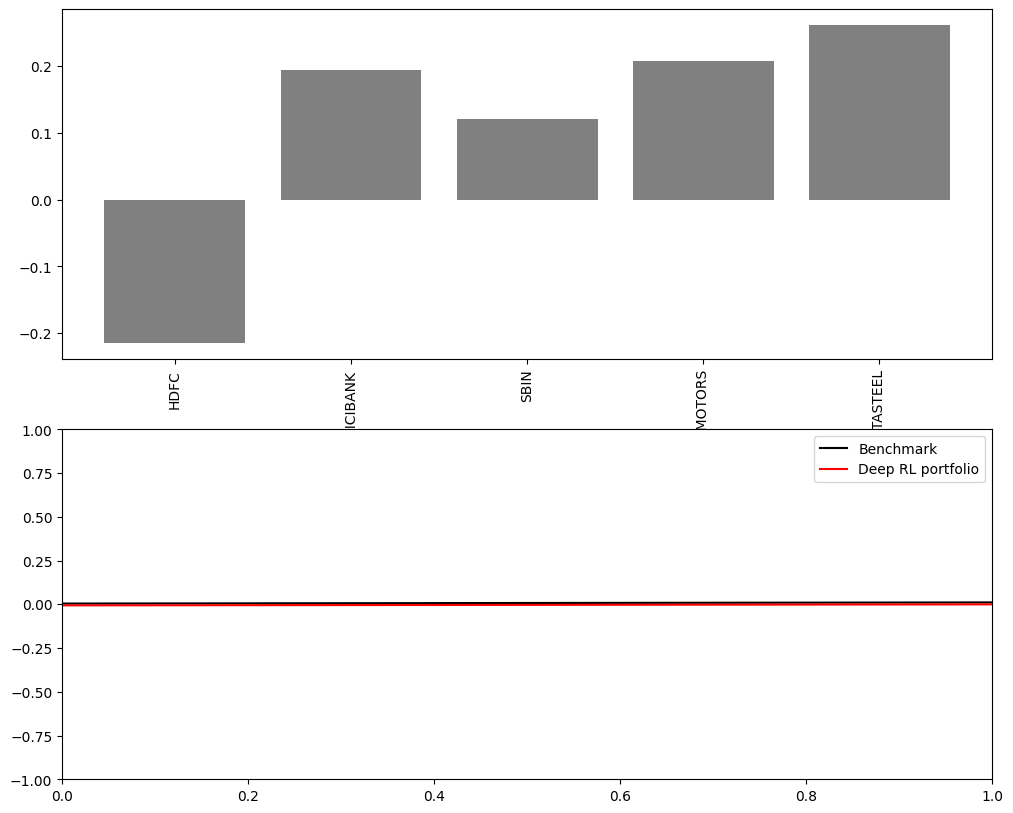

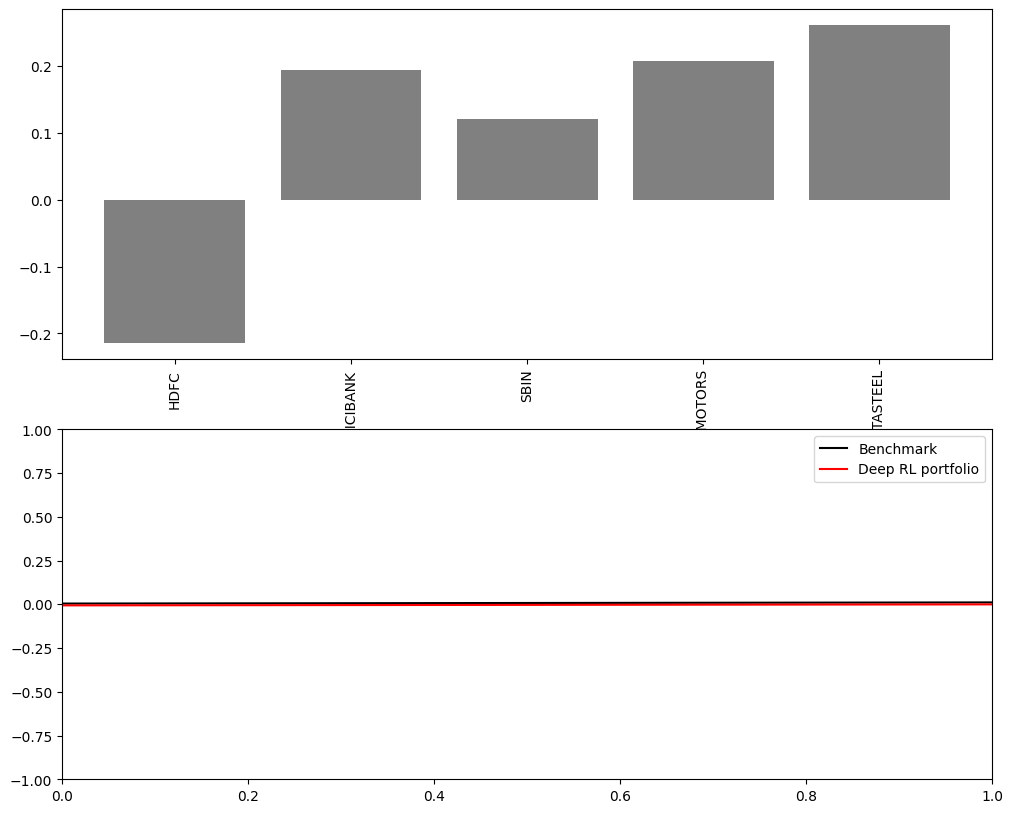

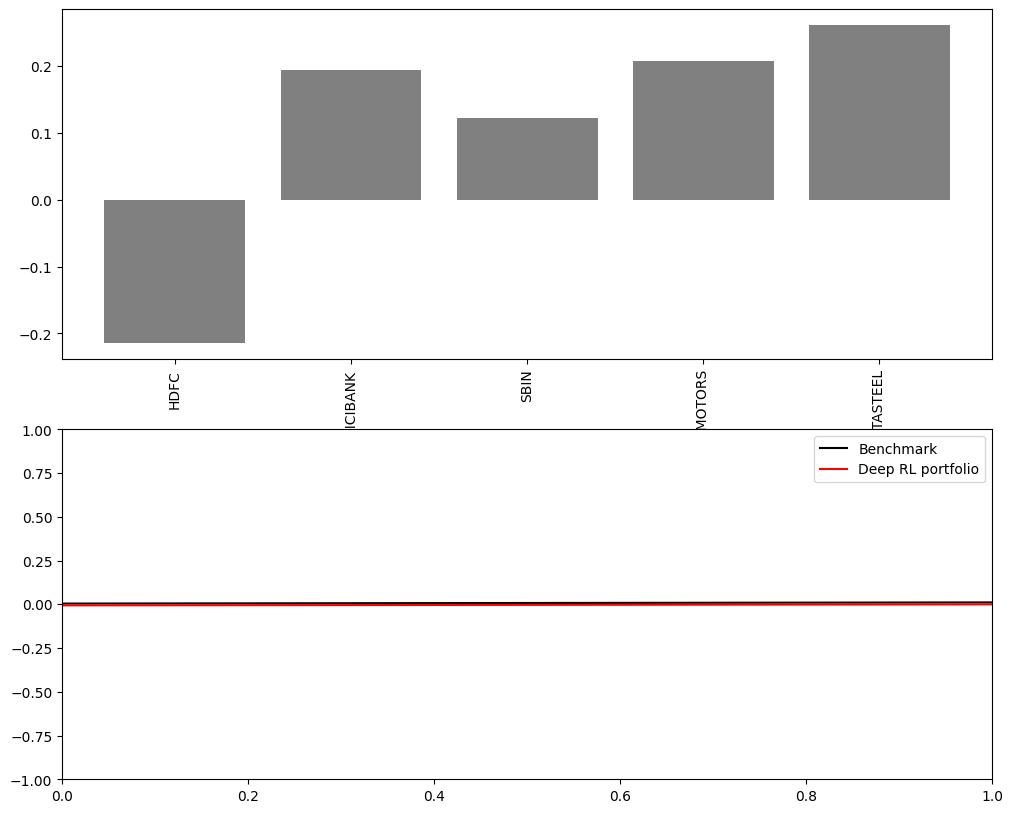

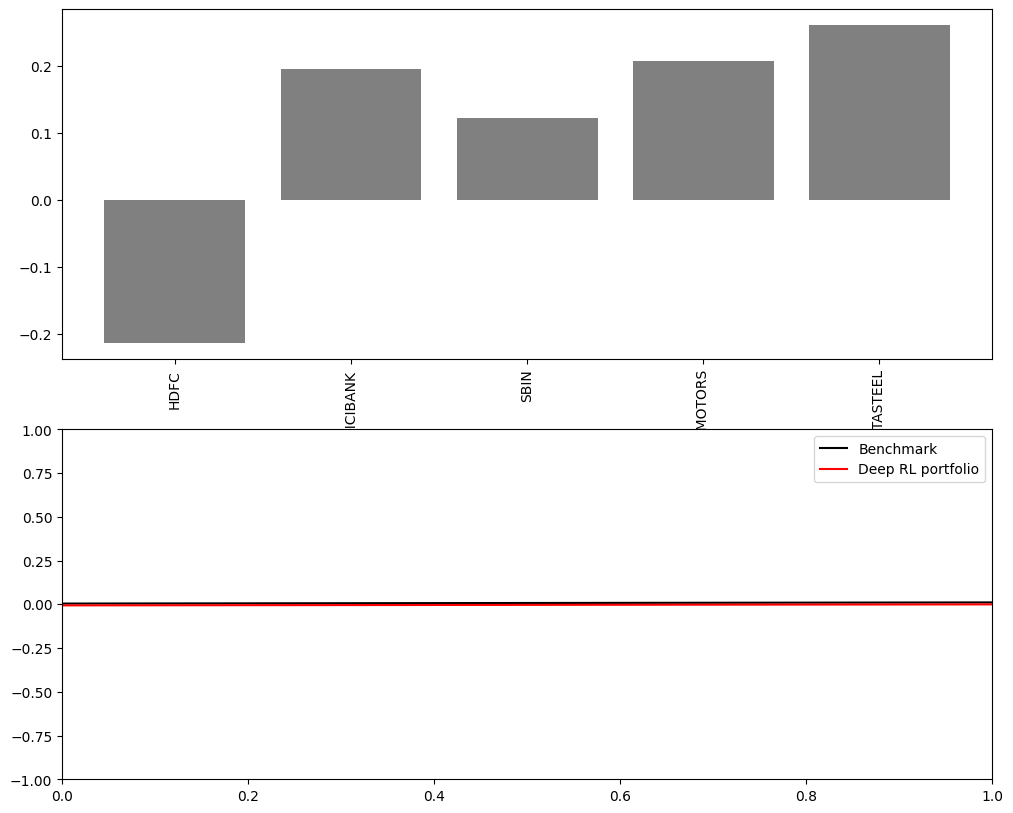

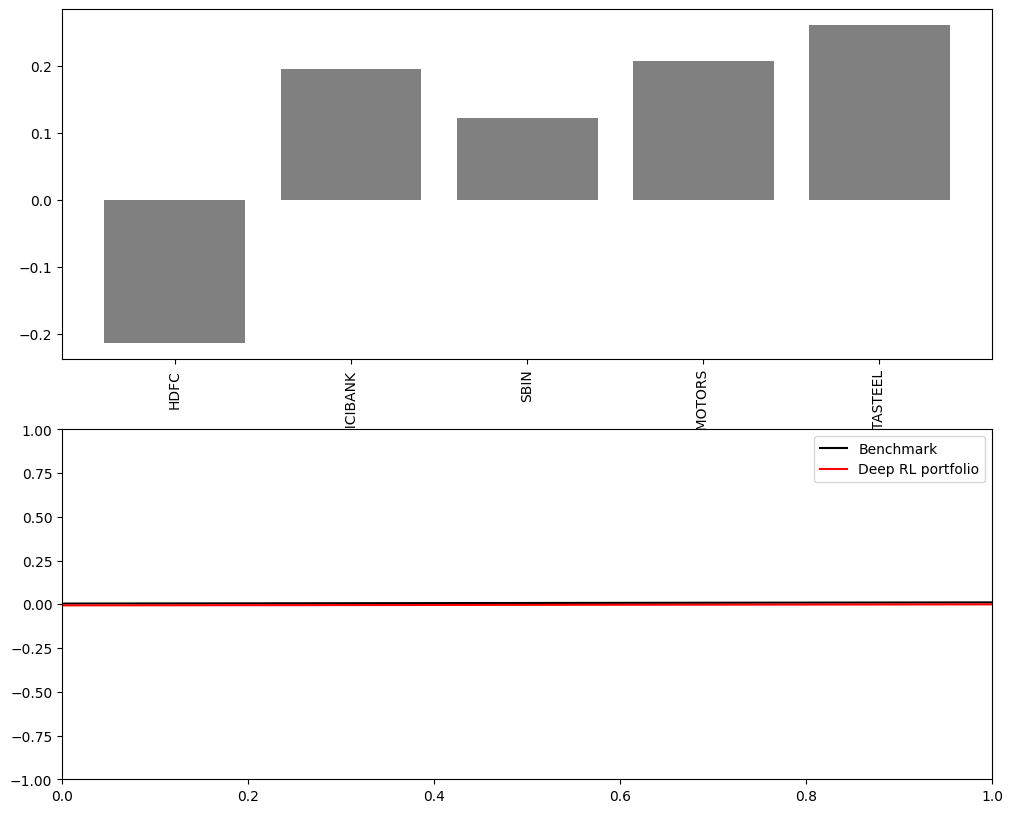

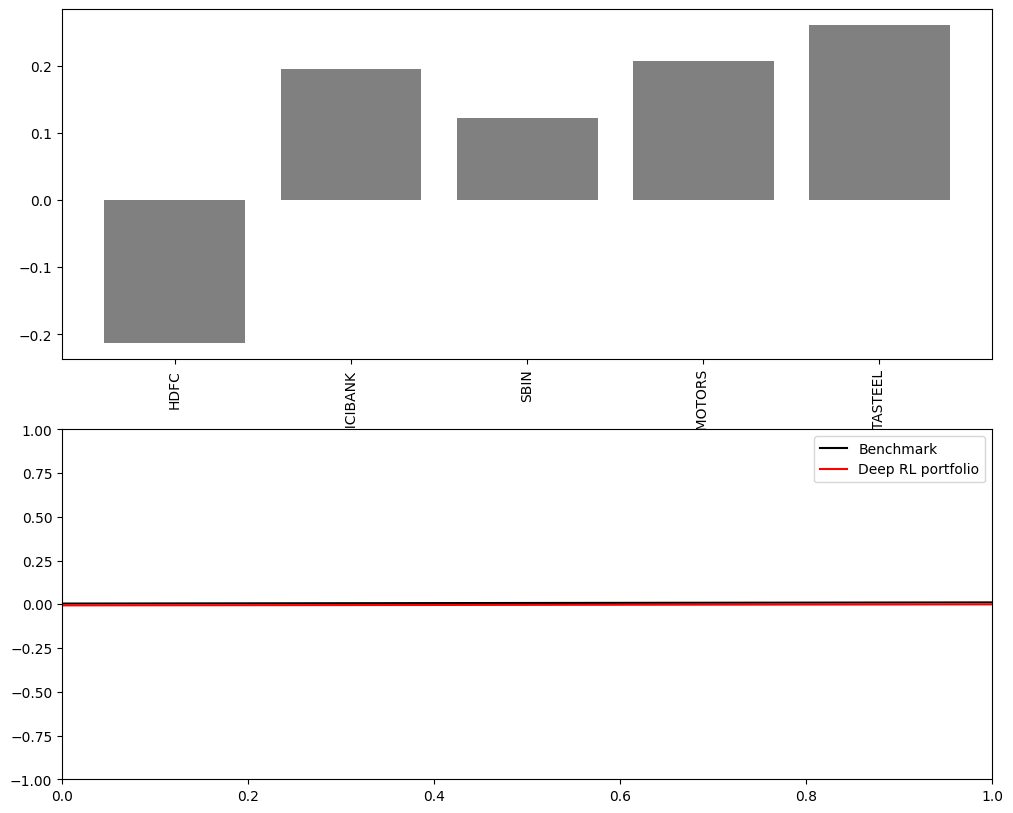

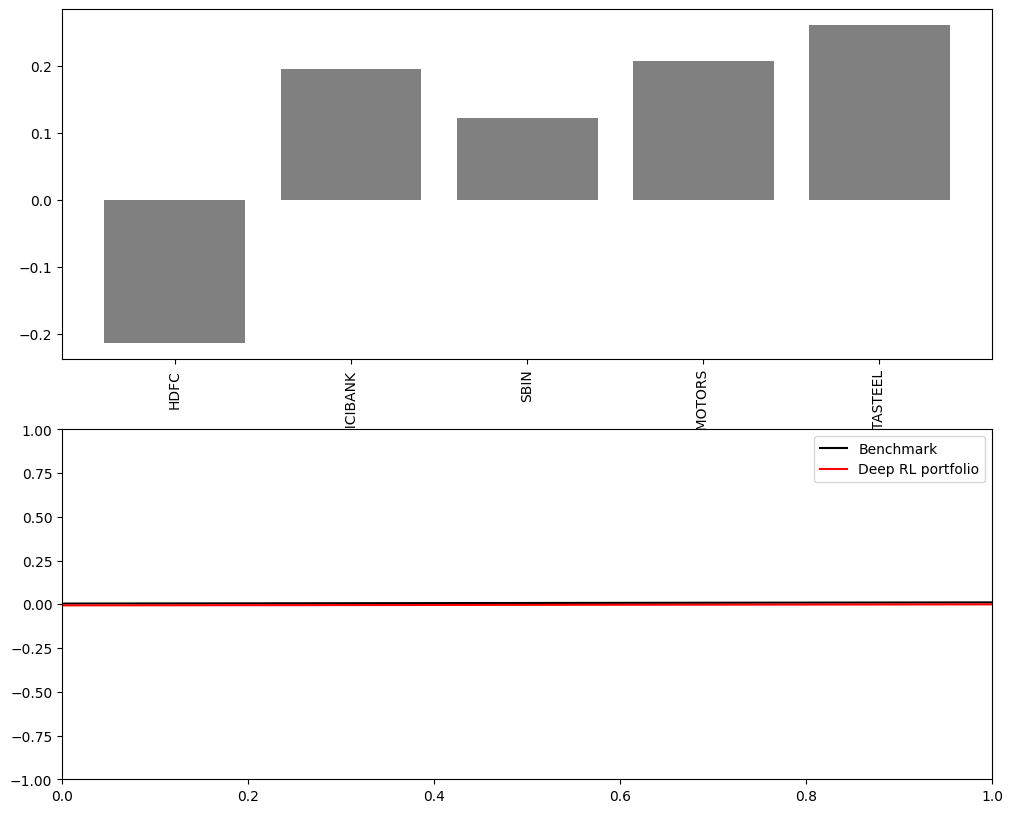

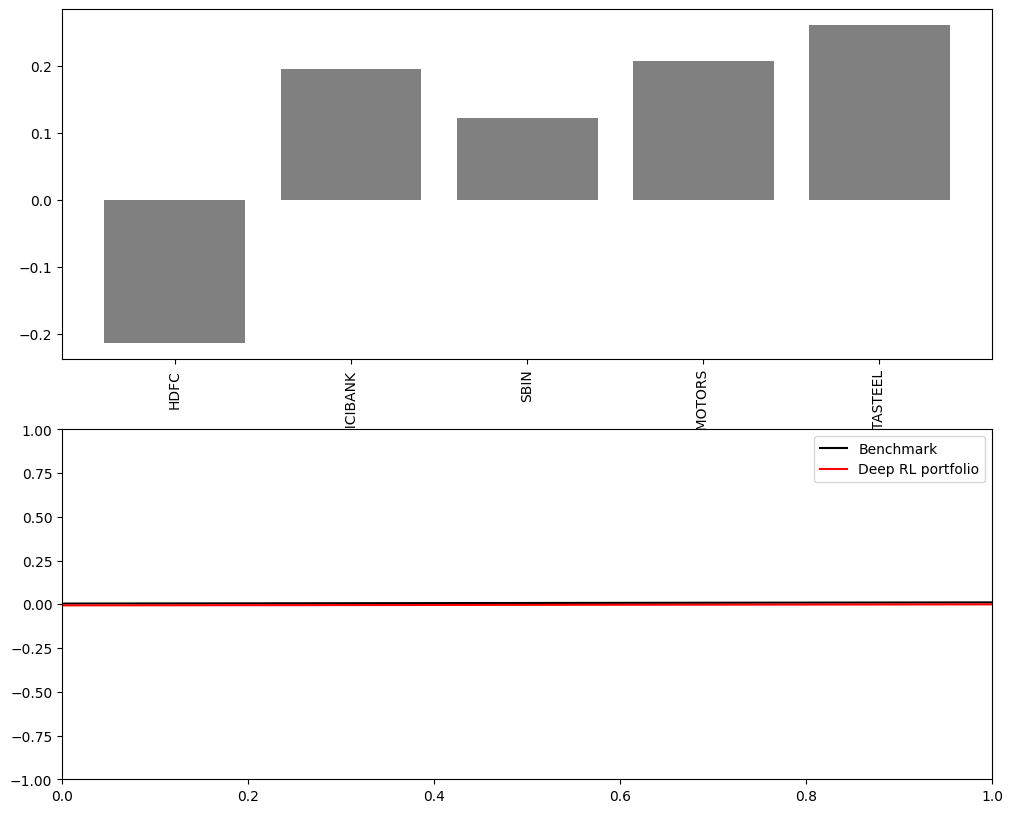

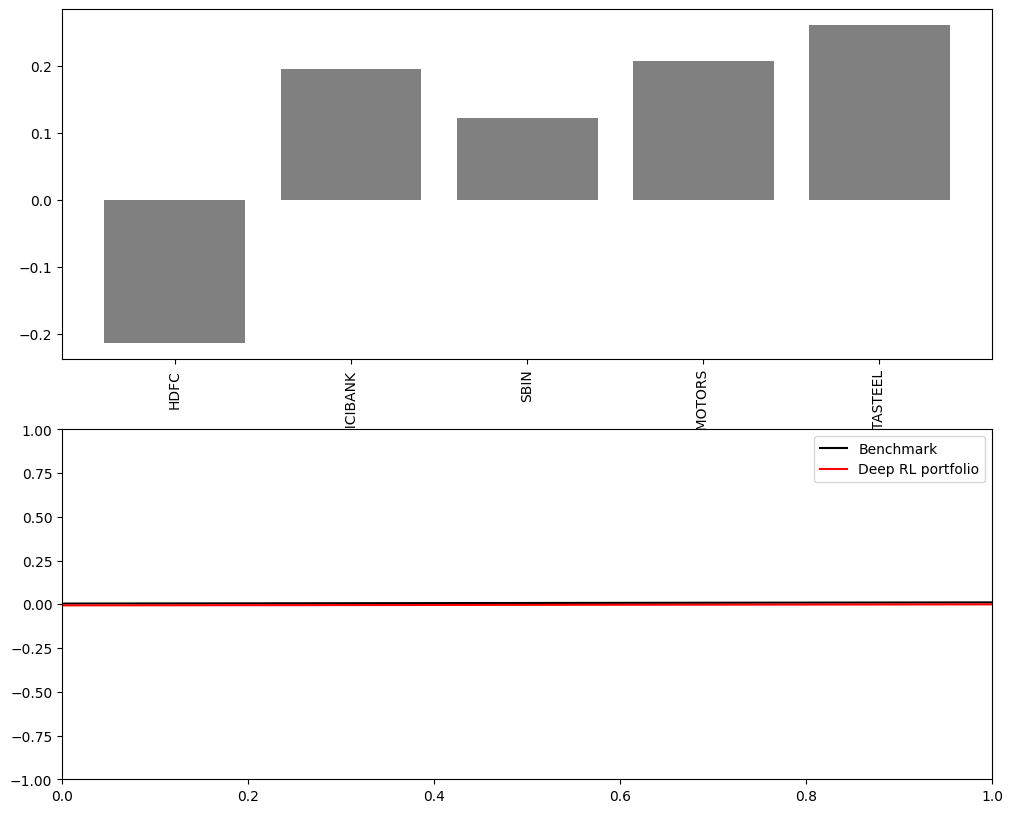

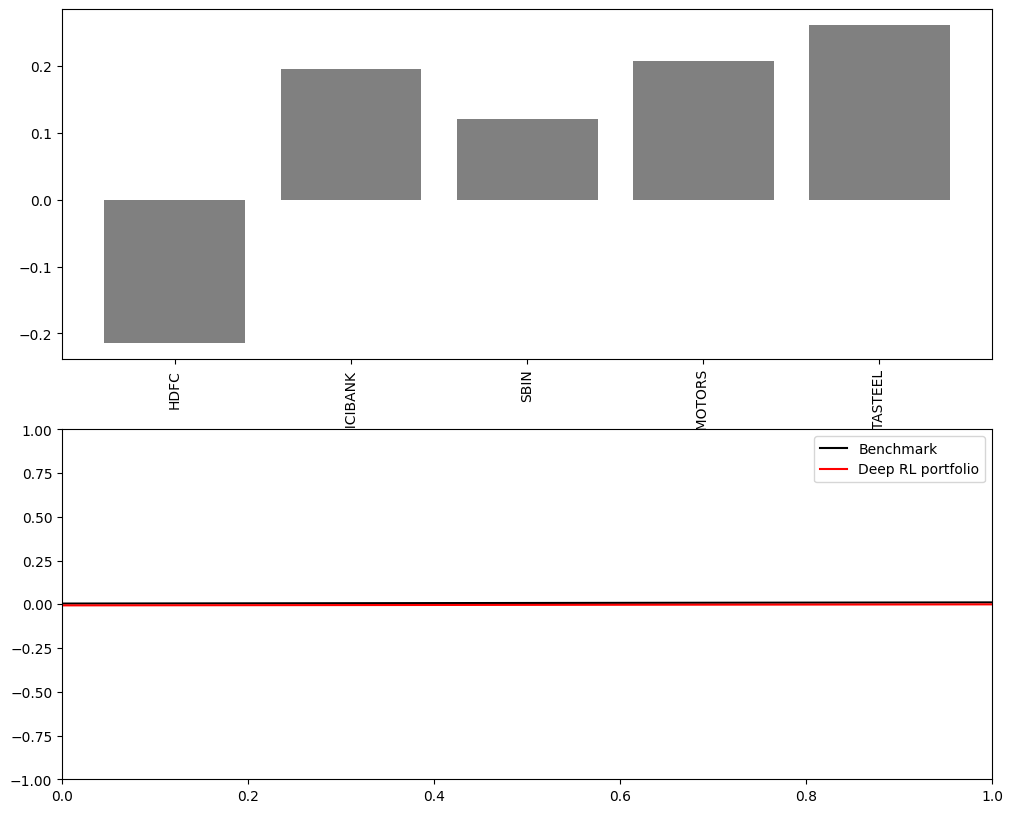

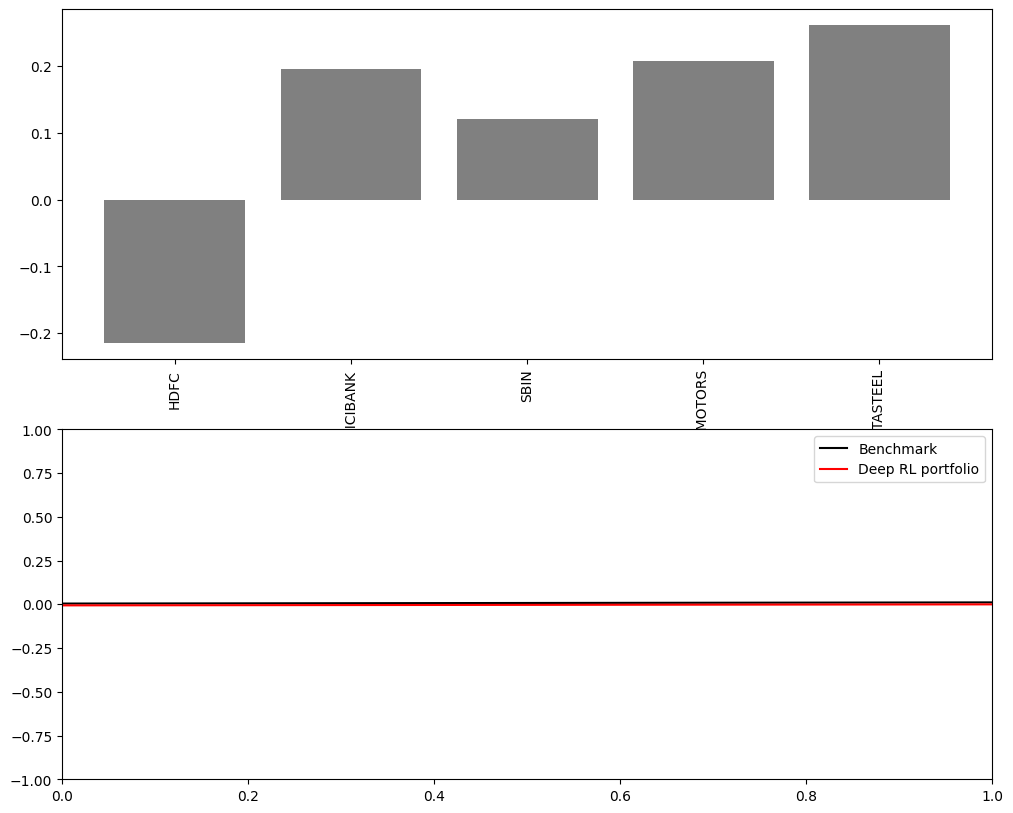

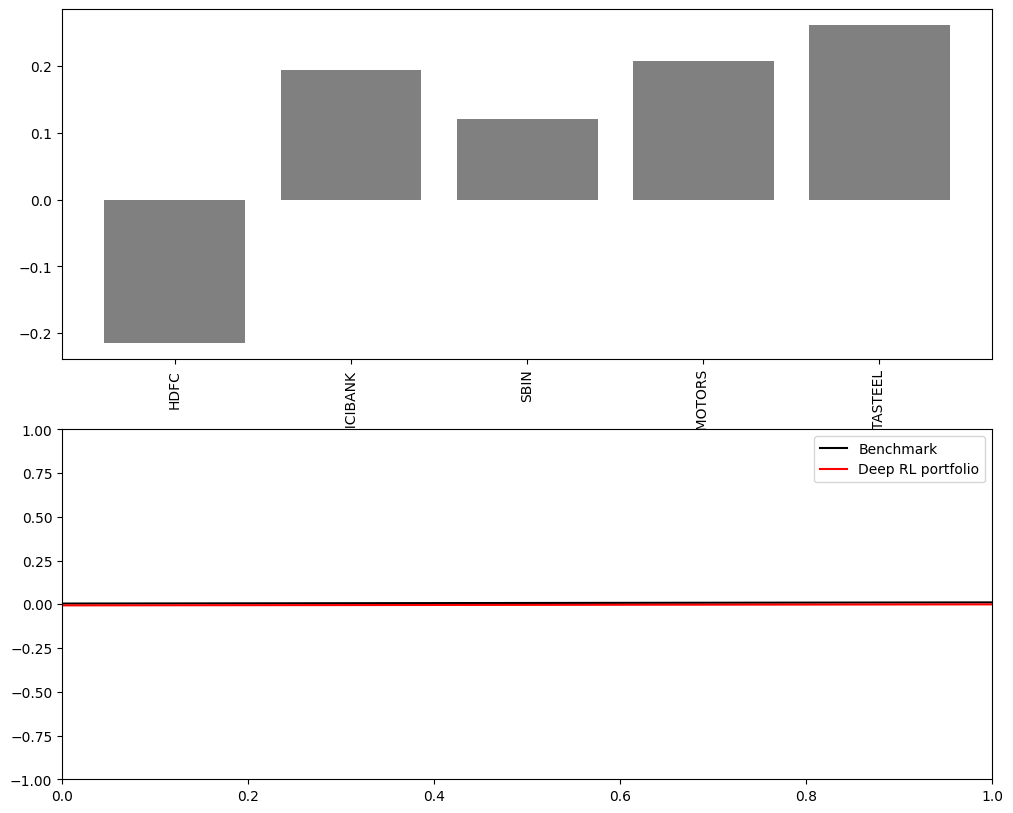

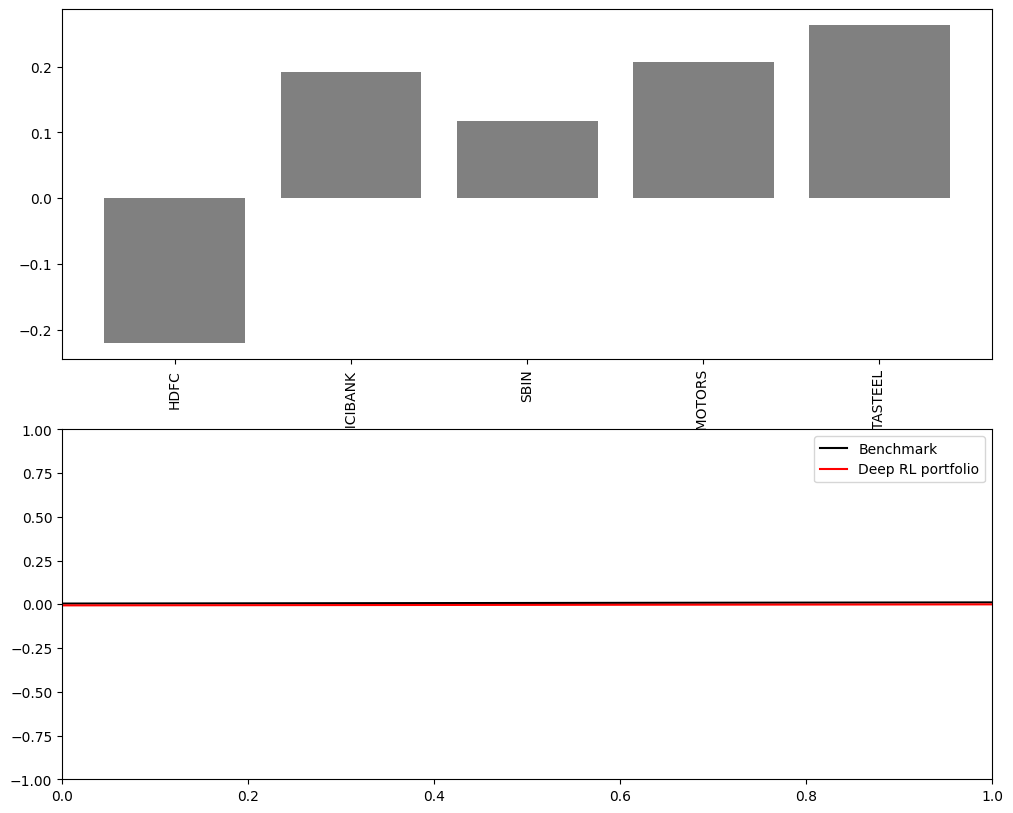

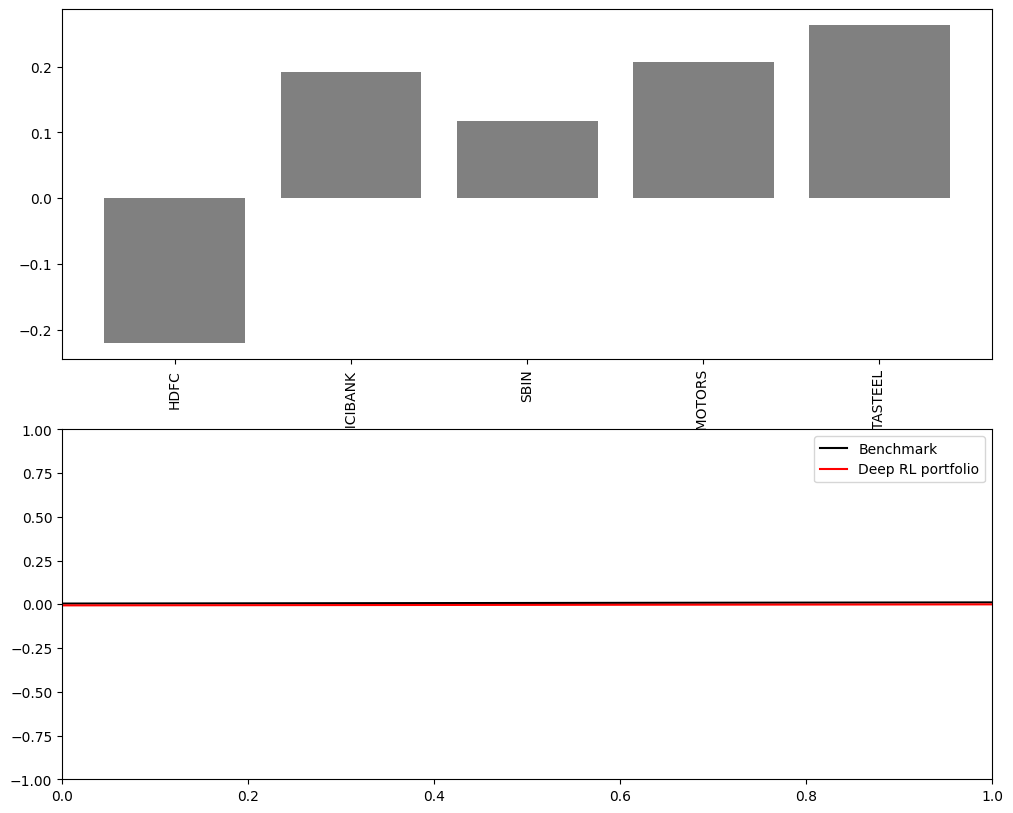

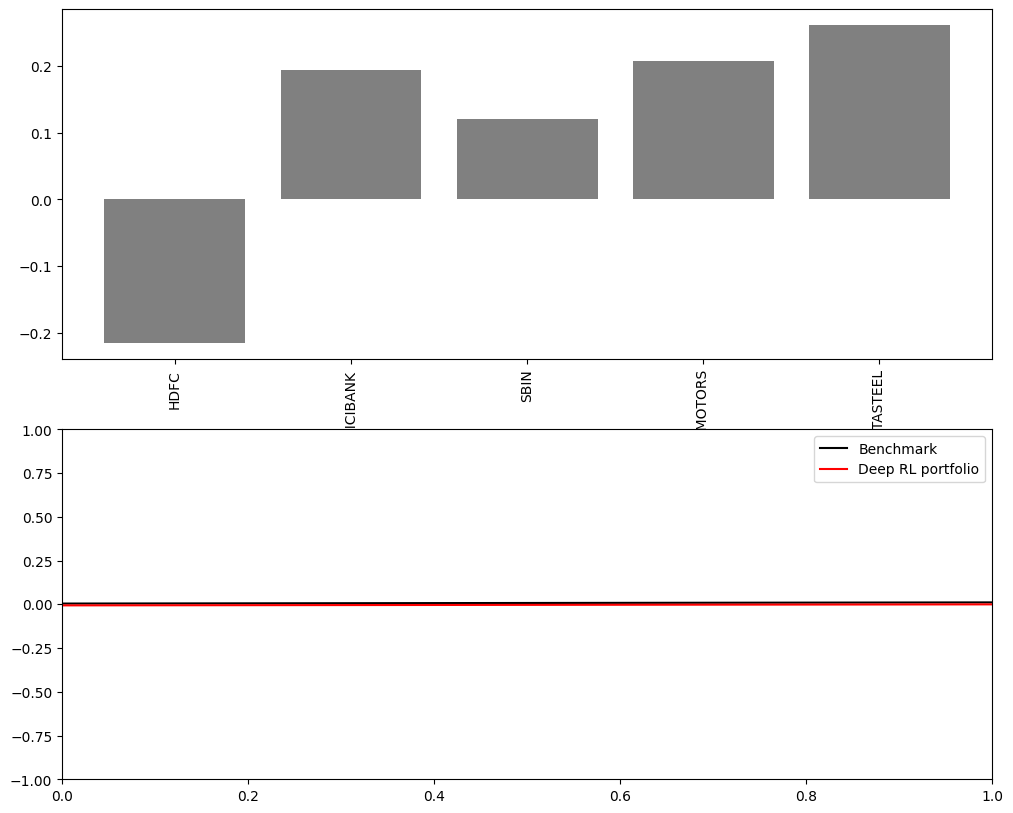

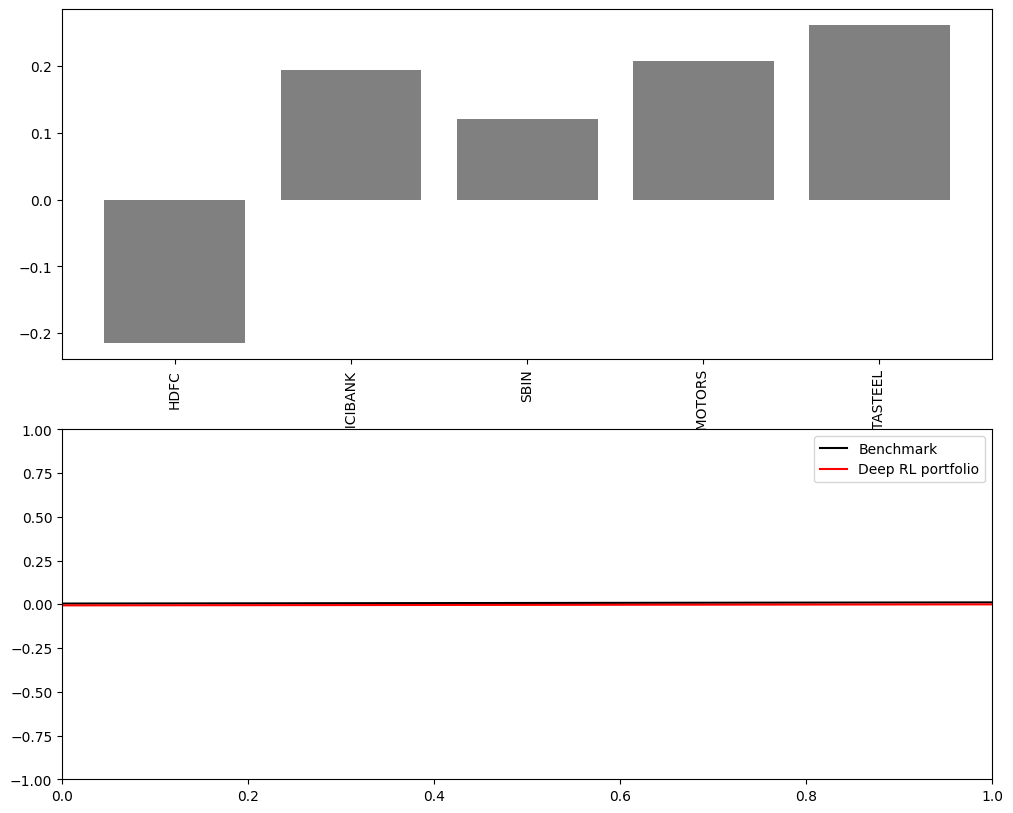

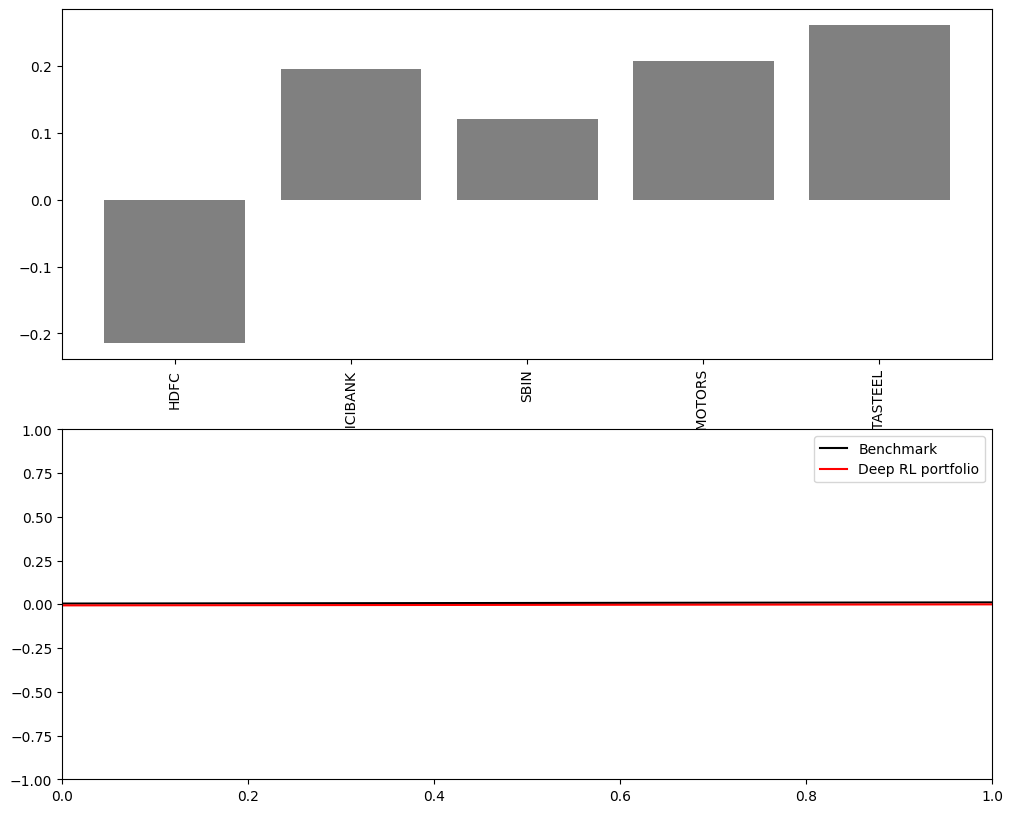

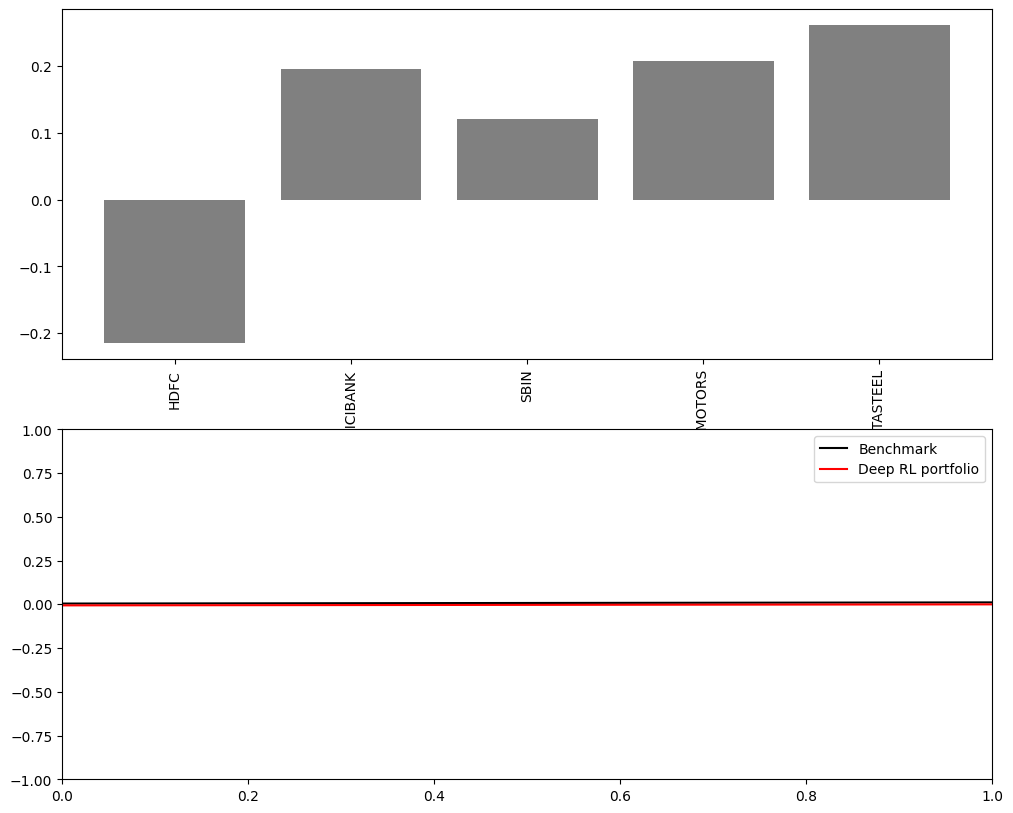

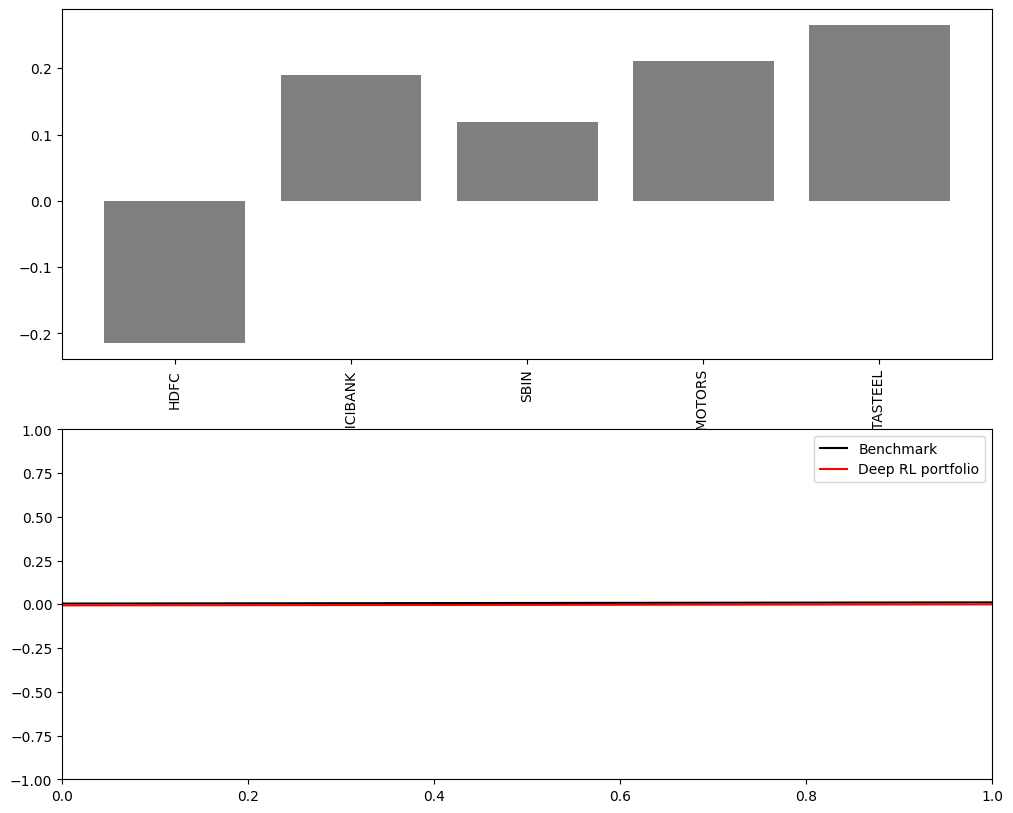

In [58]:
#Plotting the data
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

N = len(np.array([item for sublist in result_equal for item in sublist]).cumsum())

for i in range(0, len(actions_rl)):
    current_range = np.arange(0, N)
    current_ts = np.zeros(N)
    current_ts2 = np.zeros(N)

    ts_benchmark = np.array([item for sublist in result_equal[:i+1] for item in sublist]).cumsum()
    ts_target = np.array([item for sublist in result_rl[:i+1] for item in sublist]).cumsum()

    t = len(ts_benchmark)
    current_ts[:t] = ts_benchmark
    current_ts2[:t] = ts_target

    current_ts[current_ts == 0] = ts_benchmark[-1]
    current_ts2[current_ts2 == 0] = ts_target[-1]

    plt.figure(figsize = (12, 10))

    plt.subplot(2, 1, 1)
    plt.bar(np.arange(N_ASSETS), actions_rl[i], color = 'grey')
    plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')

    plt.subplot(2, 1, 2)
    plt.colormaps = current_cmap
    plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
    plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = 'Deep RL portfolio')
    plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
    plt.autoscale(False)
    plt.ylim([-1, 1])
    plt.legend()


In [59]:
import statsmodels.api as sm
from statsmodels import regression
def sharpe(R):
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))

    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()
    alpha = model.params[0]
    beta = model.params[1]

    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('RL AGENT', print_stats(result_rl_vis, result_equal_vis))

EQUAL [0.0005, 0.0182, 0.3908, 0.0, 1.0]
RL AGENT [0.0002, 0.0146, 0.2057, -0.0001, 0.7124]


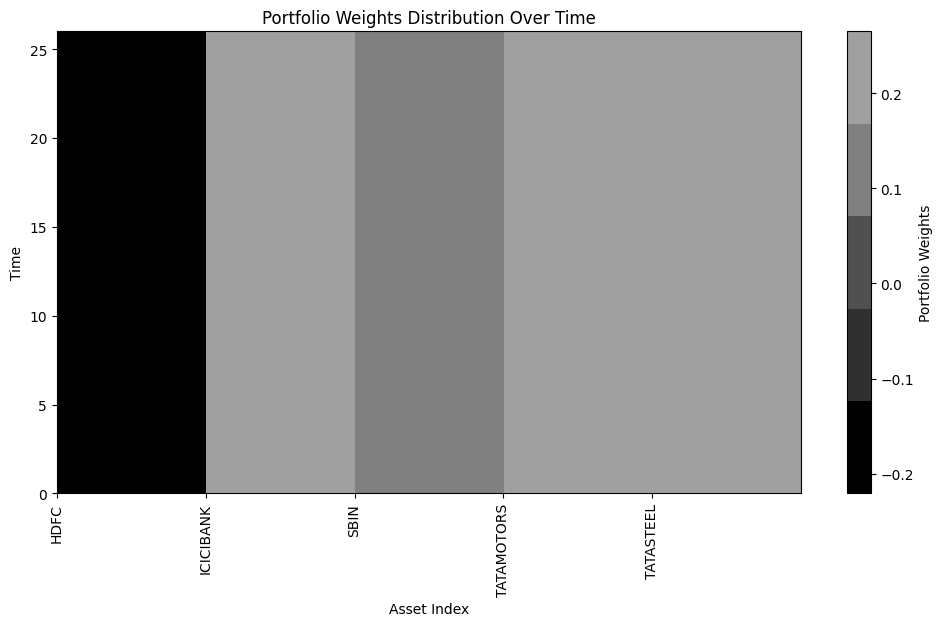

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


dark_colors = ['#000000', '#303030', '#505050', '#808080', '#A0A0A0']
custom_cmap = LinearSegmentedColormap.from_list('dark_colors', dark_colors, N=len(dark_colors))

# Portfolio Weights Distribution Over Time
plt.figure(figsize=(12, 6))
plt.imshow(actions_rl, cmap=custom_cmap, aspect='auto', extent=[0, N_ASSETS, 0, len(actions_rl)])
plt.colorbar(label='Portfolio Weights')
plt.title('Portfolio Weights Distribution Over Time')
plt.xlabel('Asset Index')
plt.ylabel('Time')
plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
plt.show()

